# Task: Predicting the shape and color of objects in a picture

Task overview: For a given image, predict a list of (object, color). the set of objects is `{square, triangle, circle}` and set of colors are `{blue, green, red}`.

# Exploratory Data Analysis (EDA)

In [1]:
%load_ext autoreload
%autoreload 2

let's look at a few sample images first.

In [2]:
## --- IMPORTs --- ##
import pandas as pd
import ast
import os
from PIL import Image
from tqdm import tqdm
import pandas as pd
import cv2
from sklearn.metrics import jaccard_score, f1_score
import numpy as np
import analysis as an

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score, accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
fig_color = '#0B2B40'
plt.rcParams.update({
    'text.color': fig_color, 'axes.labelcolor': fig_color, 
    'xtick.color': fig_color, 'ytick.color': fig_color,
    'axes.edgecolor': fig_color
})


In [3]:
## --- CONFIGS --- ##
IMAGE_BASE_DIR = './all-shapes-and-colors-v-2/'
HSV_RANGES = {
    'red': [((0, 120, 70), (10, 255, 255)), ((170, 120, 70), (180, 255, 255))],
    'green': [((40, 100, 100), (80, 255, 255))],
    'blue': [((90, 100, 100), (130, 255, 255))]
}
TRAIN_CSV_PATH = './all-shapes-and-colors-v-2/train.csv'
MODEL_SAVE_DIR = './saved_models/'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30 # Increased epochs for the new task
LEARNING_RATE = 0.001

SHAPE_CLASSES = ['circle', 'square', 'triangle']
SHAPE_TO_IDX = {shape: i for i, shape in enumerate(SHAPE_CLASSES)}
IDX_TO_SHAPE = {i: shape for i, shape in enumerate(SHAPE_CLASSES)}
ALL_CLASSES = sorted([f"{color}_{shape}" for shape in ['circle', 'square', 'triangle'] for color in ['red', 'green', 'blue']])
CLASS_TO_IDX = {cls: i for i, cls in enumerate(ALL_CLASSES)}

In [4]:
## -- HELPER FUNCTIONS --- ##

### --- Training and Evaluation Pipeline --- ###
def train_model(df, model, train_loader, val_loader, save_name, evaluate=False, pretrained_weights=None):
    """Sets up and runs the entire CNN training and evaluation pipeline."""
    
    # Create directory for saving models if it doesn't exist
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

    if pretrained_weights:
        print(f"Loading pretrained weights from {pretrained_weights}")
        model.load_state_dict(torch.load(pretrained_weights, map_location=DEVICE))
    
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    best_f1_score = 0.0
    
    if not evaluate:
        # Training loop
        for epoch in range(EPOCHS):
            model.train()
            running_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            print(f"Epoch {epoch+1} Training Loss: {running_loss/len(train_loader):.4f}")
            
            # Validation loop
            model.eval()
            all_preds = []
            all_true = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model(images)
                    preds = torch.sigmoid(outputs) > 0.5
                    all_preds.append(preds.cpu().numpy())
                    all_true.append(labels.cpu().numpy())
            
            all_preds = np.concatenate(all_preds, axis=0)
            all_true = np.concatenate(all_true, axis=0)
            
            # --- METRIC CALCULATION ---
            # Calculate Jaccard score (intersection over union) for multi-hot vectors
            avg_jaccard = jaccard_score(all_true, all_preds, average='samples', zero_division=1)
            
            # Calculate other metrics
            f1 = f1_score(all_true, all_preds, average='samples', zero_division=0)
            precision = precision_score(all_true, all_preds, average='samples', zero_division=0)
            recall = recall_score(all_true, all_preds, average='samples', zero_division=0)
            emr = accuracy_score(all_true, all_preds)

            print(f"Validation EMR: {emr:.4f} | Jaccard: {avg_jaccard:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
            
            # Save the best model based on F1 score
            if f1 > best_f1_score:
                best_f1_score = f1
                model_path = os.path.join(MODEL_SAVE_DIR, save_name)
                torch.save(model.state_dict(), model_path)
                print(f"-> New best model saved to {model_path} with F1 score: {f1:.4f}")
                
    else:
        # Validation loop
        model.eval()
        
        all_preds = []
        all_true = []
        

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                preds = torch.sigmoid(outputs) > 0.5
                all_preds.append(preds.cpu().numpy())
                all_true.append(labels.cpu().numpy())
            
        all_preds = np.concatenate(all_preds, axis=0)
        all_true = np.concatenate(all_true, axis=0)
        
        # --- METRIC CALCULATION ---
        # Calculate Jaccard score (intersection over union) for multi-hot vectors
        intersection = np.sum(np.logical_and(all_true, all_preds), axis=1)
        union = np.sum(np.logical_or(all_true, all_preds), axis=1)
        # Handle division by zero for samples with no true or predicted labels **CORRECTED**
        # jaccard_scores = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union!=0)
        jaccard_scores = np.where(union == 0, 1.0, intersection / union)
        avg_jaccard = np.mean(jaccard_scores)
        
        # Calculate other metrics
        f1 = f1_score(all_true, all_preds, average='samples', zero_division=0)
        precision = precision_score(all_true, all_preds, average='samples', zero_division=0)
        recall = recall_score(all_true, all_preds, average='samples', zero_division=0)
        emr = accuracy_score(all_true, all_preds)

        print(f"Validation EMR: {emr:.4f} | Jaccard: {avg_jaccard:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
            
    if evaluate:
        return all_true, all_preds
    
from collections import defaultdict
def evaluate_cnn_performance(model, df, transform, batch_size=32):
    """
    Efficiently evaluates the hybrid model using batch processing.
    """
    # Use the model's device
    device = next(model.parameters()).device
    model.eval()

    # 1. Set up the custom DataLoader
    eval_dataset = HybridEvaluationDataset(df, transform=transform)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

    # 2. Collect predictions in a dictionary for easy grouping
    #    key: image_path, value: set of (shape, color) tuples
    predictions_by_path = defaultdict(set)

    with torch.no_grad():
        for images, colors, paths in tqdm(eval_loader, desc="Hybrid Evaluation (Batch)"):
            images = images.to(device)
            
            # Get model predictions for the batch of masked images
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5

            # 3. Associate predictions with their color and original image
            for i in range(len(paths)):
                path = paths[i]
                color = colors[i]
                pred_indices = torch.where(preds[i] == True)[0]
                
                for idx in pred_indices:
                    shape = IDX_TO_SHAPE[idx.item()]
                    predictions_by_path[path].add((shape, color))

    # 4. Format the final output list, ordered by the original dataframe
    final_predictions = []
    for image_path in df['image_path']:
        # Get the set of predictions for this path
        preds_set = predictions_by_path.get(image_path, set())
        # Convert to a sorted list as required
        final_predictions.append(sorted(list(preds_set)))
        
    return final_predictions


def evaluate_predictions(true_labels, pred_labels):
    """Calculates Exact Match Ratio and Jaccard Score for sets of labels."""
    exact_matches = 0
    jaccard_scores = []
    
    for true, pred in zip(true_labels, pred_labels):
        true_set = set(map(tuple, true))
        pred_set = set(map(tuple, pred))
        
        if true_set == pred_set:
            exact_matches += 1
        
        # Calculate Jaccard score
        intersection = len(true_set.intersection(pred_set))
        union = len(true_set.union(pred_set))
        jaccard_scores.append(intersection / union if union > 0 else 1.0)  # Handle empty sets
        
    emr = exact_matches / len(true_labels)
    avg_jaccard = np.mean(jaccard_scores)
    return emr, avg_jaccard

# convert predictions of each row which is in shape of (shape, color) to multi-hot encoded vector
def convert_to_multi_hot(preds, all_classes):
    multi_hot = np.zeros(len(all_classes), dtype=int)
    for shape, color in preds:
        class_name = f"{color}_{shape}"
        if class_name in all_classes:
            idx = all_classes.index(class_name)
            multi_hot[idx] = 1
    return multi_hot

# --- Hybrid Prediction Pipeline ---
def get_hybrid_predictions(image_path, model, transform):
    model.eval()
    img = cv2.imread(image_path)
    if img is None: return []

    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    predictions = set()

    for color, hsv_ranges in HSV_RANGES.items():
        binary_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
        if len(hsv_ranges) > 1:
            mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
            binary_mask = cv2.bitwise_or(binary_mask, mask2)
        
        # If the mask is empty, no need to run the CNN
        if not np.any(binary_mask):
            continue
        
        # # Create the masked image and process it
        masked_img_bgr = cv2.bitwise_and(img, img, mask=binary_mask)
        
        # # we need to get rid of noise in the rgb image
        kernel = np.ones((3, 3), np.uint8)
        masked_img_bgr = cv2.morphologyEx(masked_img_bgr, cv2.MORPH_OPEN, kernel)
        masked_img_rgb = cv2.cvtColor(masked_img_bgr, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image for the transform
        masked_img_rgb = Image.fromarray(masked_img_rgb)
        image_tensor = transform(masked_img_rgb).unsqueeze(0).to(DEVICE)  # Add batch dimension
        
        
        with torch.no_grad():
            output = model(image_tensor)
            # Apply sigmoid and threshold to get multi-label predictions
            preds = torch.sigmoid(output) > 0.5
            pred_indices = torch.where(preds[0] == True)[0]
            
            for idx in pred_indices:
                shape = IDX_TO_SHAPE[idx.item()]
                predictions.add((shape, color))
            
    return sorted(list(predictions))


    
def load_data(csv_path):
    """Loads and parses the training CSV."""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found at {csv_path}")
    df = pd.read_csv(csv_path)
    # The 'label' column is a string, parse it into a Python object
    df['parsed_labels'] = df['label'].apply(ast.literal_eval)
    # Create a sorted, frozen set of labels for consistent comparison
    df['label_set'] = df['parsed_labels'].apply(lambda x: frozenset(x))
    return df

# --- OpenCV basic model ---
def get_opencv_predictions(image_path):
    """
    Analyzes a single image using OpenCV to predict shapes and colors.
    """
    img = cv2.imread(image_path)
    if img is None:
        return []
    
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    predictions = set()

    for color, hsv_ranges in HSV_RANGES.items():
        # Combine masks for colors like red that wrap around
        color_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
        if len(hsv_ranges) > 1:
            mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
            color_mask = cv2.bitwise_or(color_mask, mask2)

        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            # Ignore small contours that are likely noise
            if cv2.contourArea(cnt) < 200:
                continue

            perimeter = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * perimeter, True)
            
            # Heuristic to determine shape
            shape = None
            if len(approx) == 3:
                shape = 'triangle'
            elif len(approx) == 4:
                # Could be a square or other quadrilateral. A simple check is aspect ratio.
                _, _, w, h = cv2.boundingRect(approx)
                aspect_ratio = float(w)/h
                if 0.95 <= aspect_ratio <= 1.05:
                    shape = 'square'
            else:
                # Check for circularity
                area = cv2.contourArea(cnt)
                if perimeter > 0:
                    circularity = 4 * np.pi * (area / (perimeter * perimeter))
                    if 0.8 < circularity < 1.2:
                        shape = 'circle'
            
            if shape:
                predictions.add((shape, color))
                
    return sorted(list(predictions)) # Return a sorted list for consistency

In [5]:
main_df = load_data(TRAIN_CSV_PATH)

In [6]:
# let's start with the train.csv
df = pd.read_csv('./all-shapes-and-colors-v-2/train.csv')
df['parsed_labels'] = df['label'].apply(ast.literal_eval)
df.head()

,image_path,label,parsed_labels
0,train_dataset/img_0.png,"[('triangle', 'red'), ('square', 'green')]","[(triangle, red), (square, green)]"
1,train_dataset/img_1.png,"[('triangle', 'green'), ('circle', 'blue')]","[(triangle, green), (circle, blue)]"
2,train_dataset/img_2.png,"[('square', 'green'), ('triangle', 'green')]","[(square, green), (triangle, green)]"
3,train_dataset/img_3.png,"[('circle', 'blue')]","[(circle, blue)]"
4,train_dataset/img_4.png,"[('circle', 'green')]","[(circle, green)]"


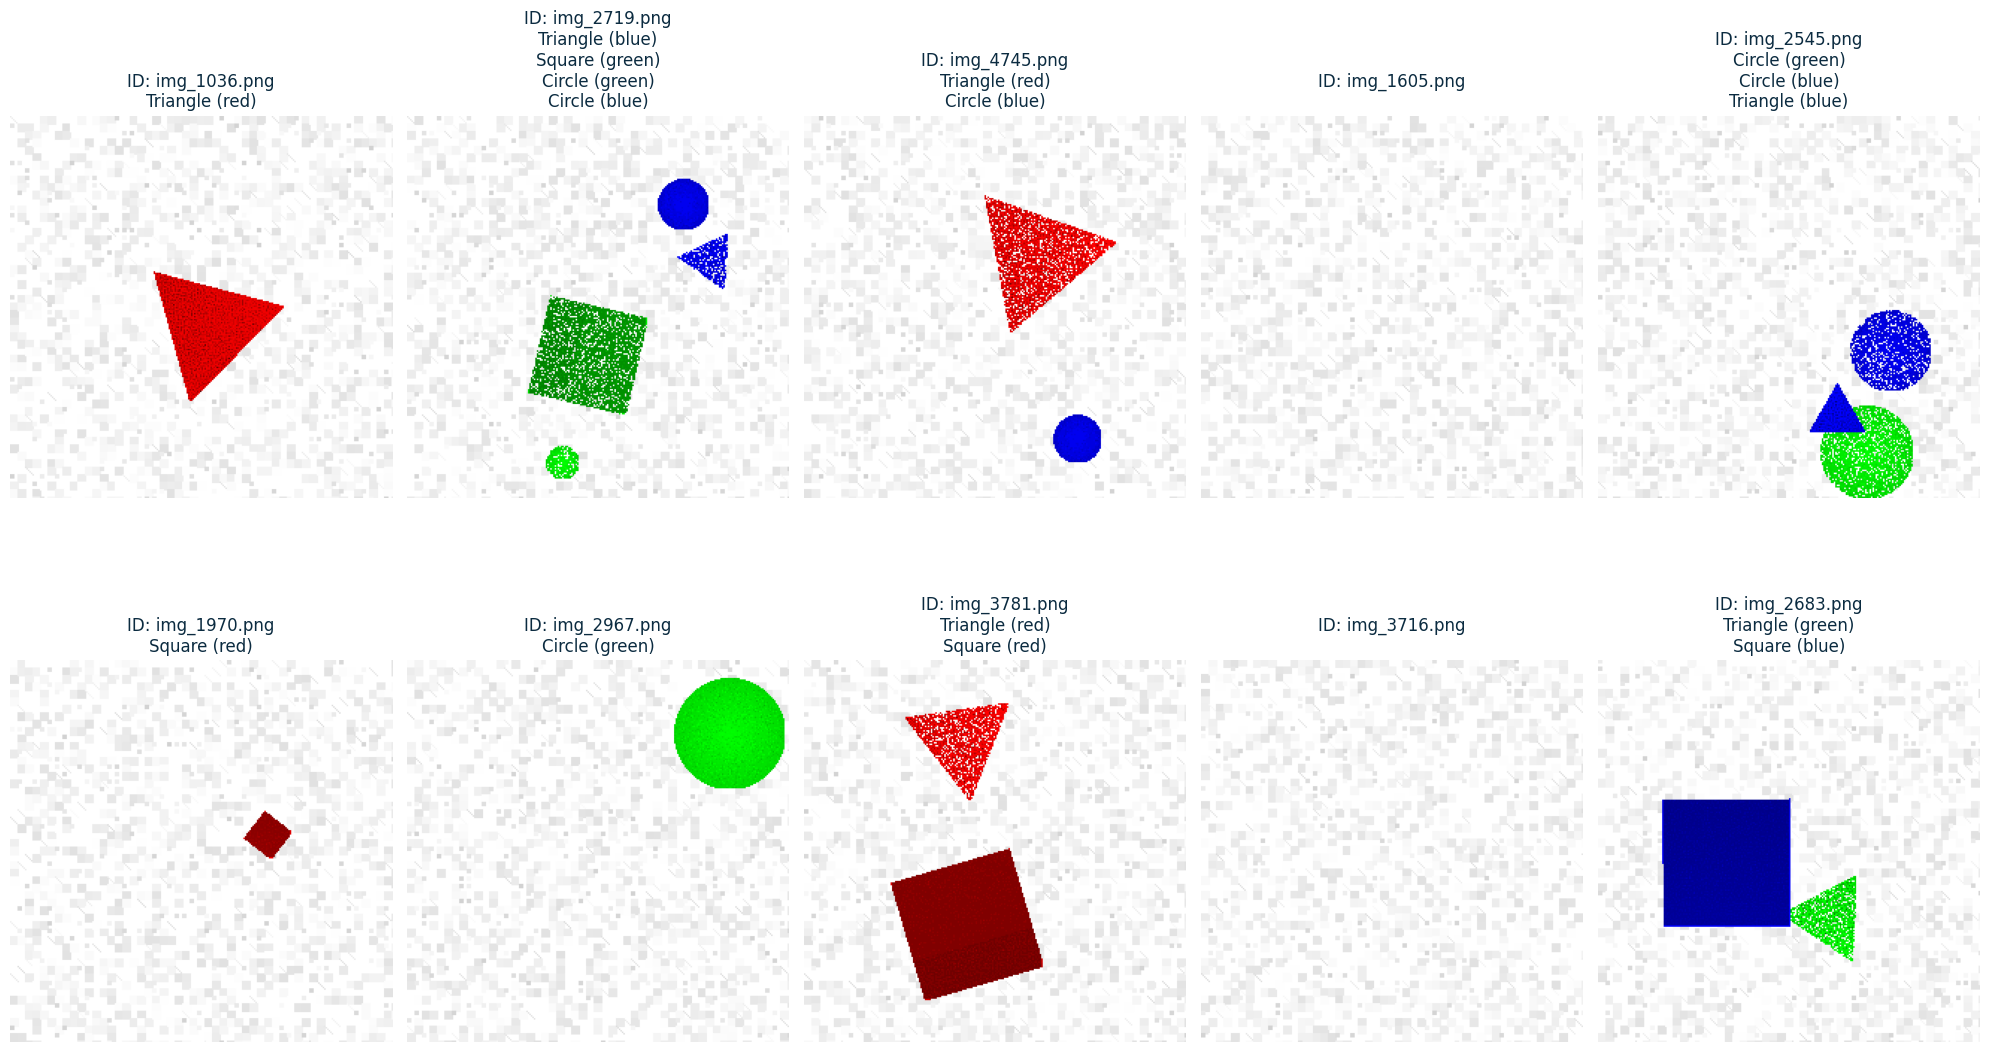

In [ ]:
sample_df = df.sample(min(10, len(df)))

plt.figure(figsize=(20, 15))
for i, (idx, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 5, i+1)

    image_path = row['image_path']
    img = Image.open(os.path.join(IMAGE_BASE_DIR, image_path))
    plt.imshow(img)
    title_text = '\n'.join([f"{shape.capitalize()} ({color})" for shape, color in row['parsed_labels']])
    plt.title(f"ID: {os.path.basename(image_path)}\n{title_text}", fontsize=12)
    plt.axis('off')
    plt.tight_layout()

Visually inspecting the data, there are several interesting characteristics:
- we have images without any object
- background seems to have a nois-like texture
- object's fillings (color) can be solid, or even noisy (both white and black speckles)
- objects may overlap (e.g., imageID: 100, 4515)
    - some objects are on top of each other (either same or different color) -- we will see this later.
- we can have multiple objects with the same color

Let's look at some statistics,
- a) Distribution of Object Count per Image (how many object we have in an image?)
- b) Frequency of Individual Shapes and Colors (is our data balanced?)
- c) Frequency of Composite Shape-Color Classes (is our shape-color pair balanced?)

In [ ]:
# Data Preparation for Multi-Label Classification analysi
# Count the number of objects in each image
df['object_count'] = df['parsed_labels'].apply(len)

# Extract just the shapes
df['shapes'] = df['parsed_labels'].apply(lambda x: [shape for shape, color in x])

# Extract just the colors
df['colors'] = df['parsed_labels'].apply(lambda x: [color for shape, color in x])

# Create composite labels (e.g., 'red_circle') for multi-label analysis
df['composite_labels'] = df['parsed_labels'].apply(lambda x: [f"{color}_{shape}" for shape, color in x])

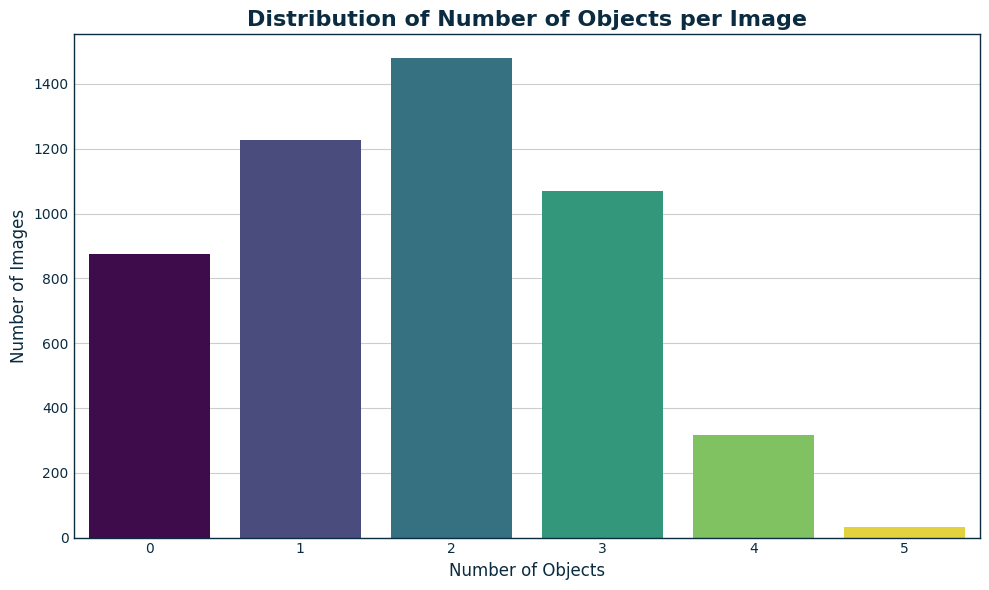

In [6]:
# a) Distribution of Object Count per Image
plt.figure(figsize=(10, 6))
sns.countplot(x='object_count', data=df, palette='viridis', hue='object_count', legend=False)
plt.title('Distribution of Number of Objects per Image', fontsize=16, weight='bold')
plt.xlabel('Number of Objects', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.tight_layout()
plt.show()

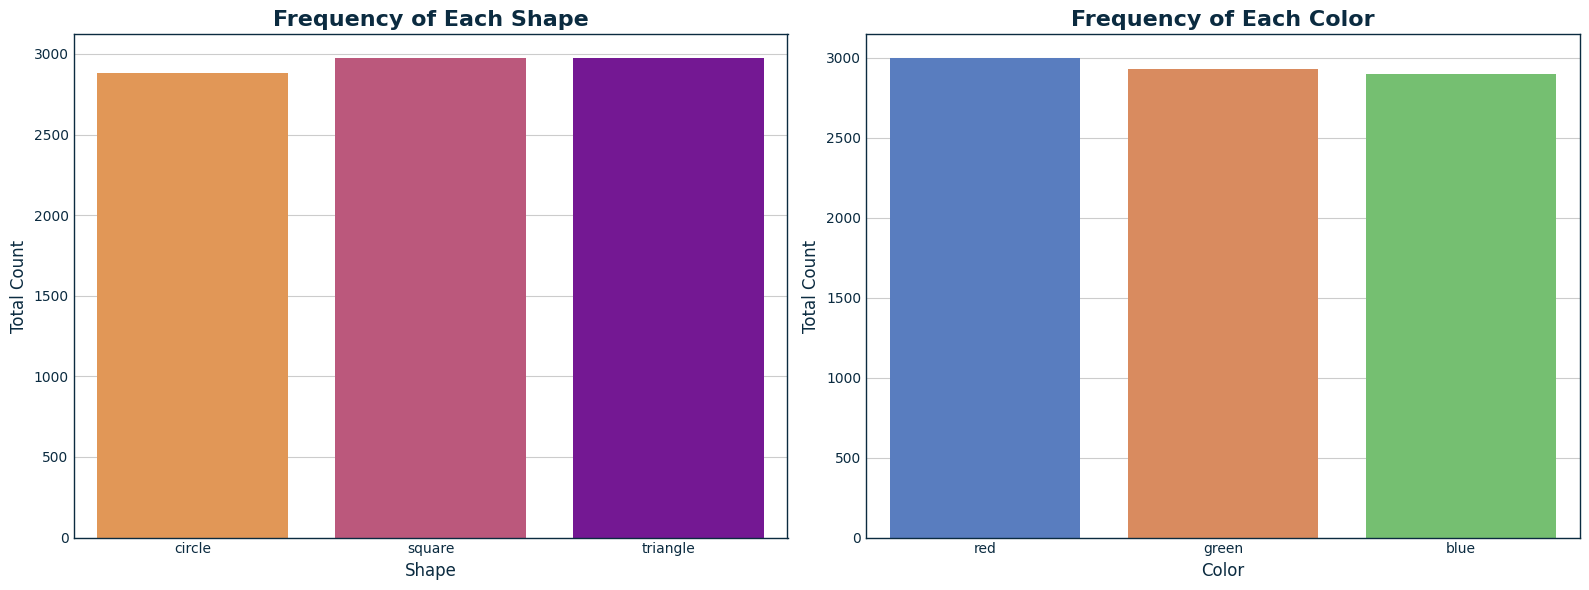

In [7]:
# b) Frequency of Individual Shapes and Colors
# Flatten the lists of shapes and colors into single lists
all_shapes = [shape for sublist in df['shapes'] for shape in sublist]
all_colors = [color for sublist in df['colors'] for color in sublist]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(x=all_shapes, ax=axes[0], palette='plasma', order=['circle', 'square', 'triangle'], hue=all_shapes, legend=False)
axes[0].set_title('Frequency of Each Shape', fontsize=16, weight='bold')
axes[0].set_xlabel('Shape', fontsize=12)
axes[0].set_ylabel('Total Count', fontsize=12)

sns.countplot(x=all_colors, ax=axes[1], palette='muted', order=['red', 'green', 'blue'], hue=all_colors, legend=False)
axes[1].set_title('Frequency of Each Color', fontsize=16, weight='bold')
axes[1].set_xlabel('Color', fontsize=12)
axes[1].set_ylabel('Total Count', fontsize=12)

plt.tight_layout()
plt.show()

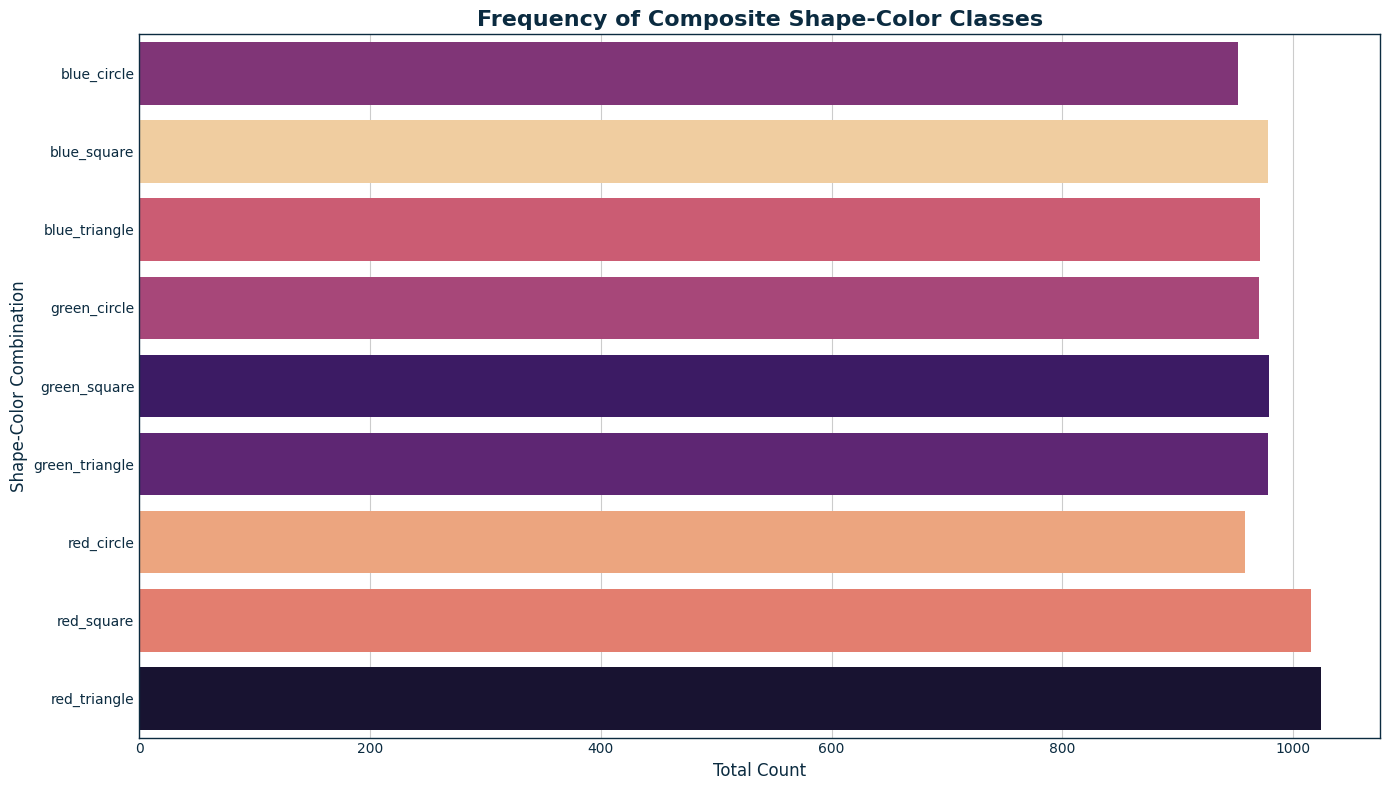

In [8]:
# c) Frequency of Composite Shape-Color Classes
all_composite_labels = [label for sublist in df['composite_labels'] for label in sublist]
composite_order = sorted(list(set(all_composite_labels)))

plt.figure(figsize=(14, 8))
sns.countplot(y=all_composite_labels, palette='magma', order=composite_order, hue=all_composite_labels, legend=False)
plt.title('Frequency of Composite Shape-Color Classes', fontsize=16, weight='bold')
plt.xlabel('Total Count', fontsize=12)
plt.ylabel('Shape-Color Combination', fontsize=12)
plt.tight_layout()
plt.show()

Analysis: looks like we have a pretty balanced dataset in terms of color, shape, and shape-color distribution. the only concern, as of now, could be the class imbalance, the number of images with 5 objects in it which is drastically fewer than other categories.

*note*: during train/test we need to carefully split the dataset considering the class imbalance

# Establishing A Baseline Model

now that we have a better understanding of the data, what it looks like and what its distribution is like, we can go ahead and setup a baseline. 

the baseline helps establish a minimum acceptable ratio. We will use `openCV` to establish a baseline.

The baseline model is a basic openCV heuristics. this includes mapping the image to HSV for color detection and using contours and counting number of edges for identifying the shape.

## openCV model - basic

the openCV model uses HSV to classify color and uses contours to classify shapes (using the number of detected vertices it can tell if an object is a triangle, square, or circle)

In [36]:
print("--- Phase 1.1: Classical CV Benchmark (OpenCV) ---")
opencv_preds = []
for img_path in tqdm(main_df['image_path'], desc="OpenCV Processing"):
    full_path = os.path.join(IMAGE_BASE_DIR, img_path)
    opencv_preds.append(get_opencv_predictions(full_path))

true_labels_list = main_df['parsed_labels'].apply(lambda x: sorted(list(x))).tolist()
emr_cv, jaccard_cv = evaluate_predictions(true_labels_list, opencv_preds)

print("\n--- OpenCV Benchmark Results ---")
print(f"Exact Match Ratio (EMR): {emr_cv:.4f}")
print(f"Average Jaccard Score: {jaccard_cv:.4f}")

--- Phase 1.1: Classical CV Benchmark (OpenCV) ---


OpenCV Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

OpenCV Processing: 100%|██████████| 5000/5000 [00:11<00:00, 424.48it/s]



--- OpenCV Benchmark Results ---
Exact Match Ratio (EMR): 0.6830
Average Jaccard Score: 0.6619


we scored an average Jaccard score of `66.19%` that suggests that we can easily detect (shape,color) pair for 2/3 of the dataset.

we also have a relatively high EMR ratio `68.30%`. EMR is a strict, all-or-nothing metric. it only scores the predictions that match **perfectly** with the ground truth.

however, having a higher EMR score than Jaccard potentially suggests an imbalance in the model's prediction. specifically, we can hypothesize that:

- when model is right, it's perfect. over 2/3rds of the time it scores the perfect score.
- when the model is wrong, it's very wrong. particularly because of the more complex images.

we can investigate this further by looking at:

- how many objects we over/under predicted for each class of image (categorized by their number of objects)

- confusion matrix for shape and color

### openCV model - analysis

In [ ]:
an.compare_object_counts(true_labels_list, opencv_preds)

--- Object Count Comparison ---
 Num Objects  True Count  Predicted Count  Difference
           0         874              956          82
           1        1228             1694         466
           2        1479             1615         136
           3        1069              647        -422
           4         318               87        -231
           5          32                1         -31


let's take the time to analyze some of these results,

from the class prediction, for instance we see that there's a total of 32 images that has 5 objects in it. the model only predicts one image to have 5 objects in it. 

summarizing this information tells us that:
- over-prediction on simple images: the model tends to only identify 1 to 2 objects per image. it predicted far more iamges had 1 object (+466) and 2 objects (+136) than was true.

- severe under-prediction on complex images: the model fails badly when the real number of objects are more than 3, perhaps because of the overlaps etc. specifically:

    * it missed identified the correct object count for 422 images that actually had 3 objects.
    * it missed 231 images that had 4 objects.
    * it almost completely failed on images with 5 objects, only identifying 1 out of 32 correctly.


--- Generating Shape Confusion Matrix ---


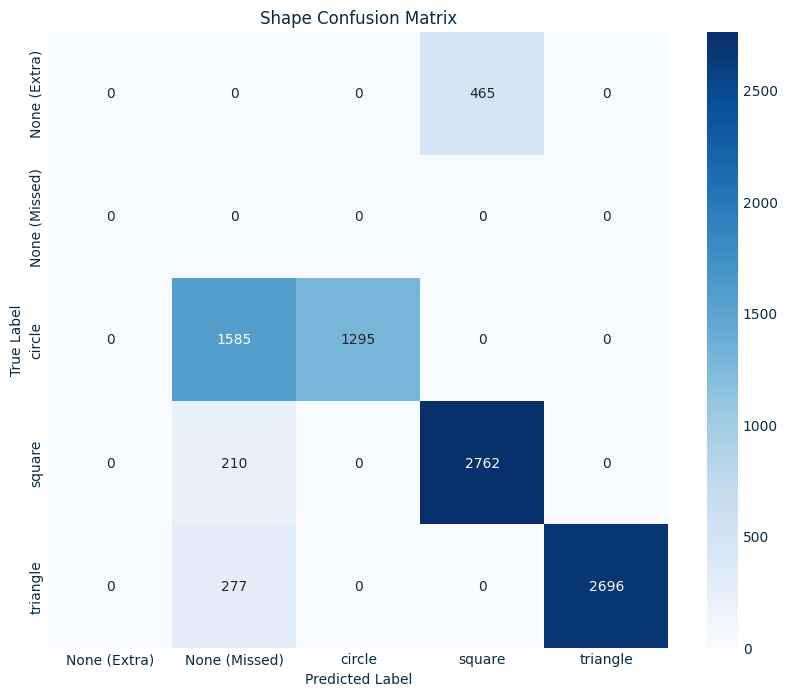


--- Generating Color Confusion Matrix ---


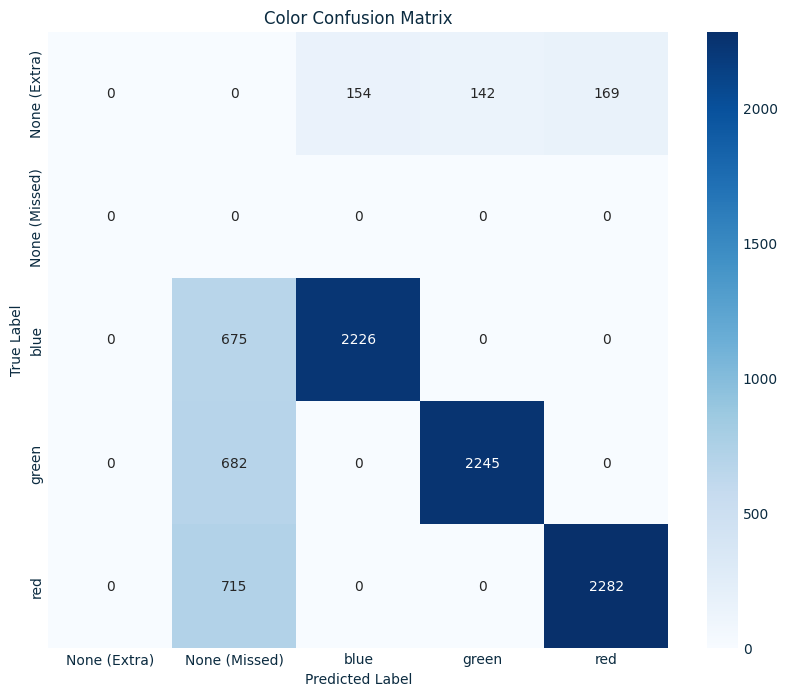

In [15]:
an.plot_confusion_matrix(true_labels_list, opencv_preds, analysis_type='shape')
an.plot_confusion_matrix(true_labels_list, opencv_preds, analysis_type='color')

From the confusion matrices, 

**Observation 1**: The None (Missed) shows that the model missed `2,072` (675+682+715) objects, that were actually in the image. This explains the under counting we observed with more complex images.

* **circles are the most problematic** the model is particularly bad at finding circles. it missed `1,585` circles, even more than what it has identified correctly (1,295). 

* **squares and triangles** are detected more reliably, but still we missed about 7% of them.

**Observation 2** The None (Extra) shows the false positives generated by the model (predicting objects that aren't there).
* overall the model hallucinated 465 objects and **every single of it was a `square`**. 

Interestingly, the model almost never confuses one shape for another (e.g., calling a circle a triangle) or one color for another.

In [ ]:
an.analyze_opencv_failures(main_df, get_opencv_predictions)

we can also inspect the failed cases **visually**. failed predictions reveal several underlying issues:

- the noisy pattern is perhaps the cause for **misclassification**.
- object occlusion is the most common cause of failure.
- more interestingly, there are cases where two objects are on top of each other, this makes it impossible to tell apart the objects. (see below)

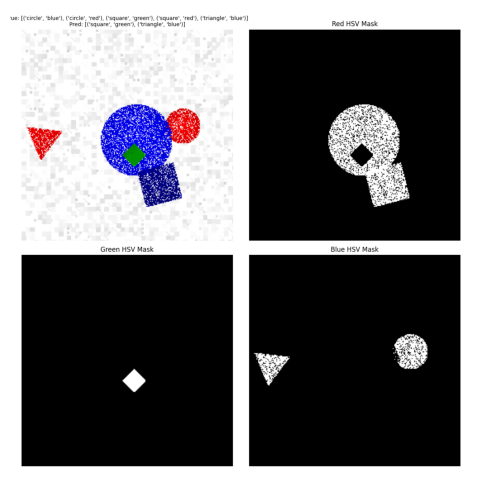

In [21]:
# load image from analysis
import matplotlib.pyplot as plt
sample_cv_failure = cv2.imread('./analysis_results/opencv_failures/failure_img_69.png')
plt.figure(figsize=(8, 6))
plt.imshow(sample_cv_failure)
plt.axis('off')
plt.show()

-- since the algorithm works by masking the image based on their "color" and then it proceeds to classify the images based on their mask. therefore, if two objects with the same color are `touching borders` or one is `completely on top of the other one`, there's no information about that object. and if they have different color, `there will be a hole in the other object`.

# CNN model - basic

let's evaluate how a simple CNN model performs on this task.

In [ ]:
class ShapesDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = Image.open(img_path).convert("RGB")
        
        # Create multi-hot encoded label tensor
        labels = torch.zeros(len(ALL_CLASSES), dtype=torch.float32)
        composite_labels = [f"{color}_{shape}" for shape, color in row['parsed_labels']]
        for label in composite_labels:
            labels[CLASS_TO_IDX[label]] = 1
            
        if self.transform:
            image = self.transform(image)
            
        return image, labels

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Calculate the flattened size after convolutions
        # Input: 128 -> 64 -> 32 -> 16. So 64 * 16 * 16
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    

def run_cnn_training(df, evaluate=False):
    """Sets up and runs the entire CNN training and evaluation pipeline."""
    print("\n--- Phase 1.2: Simple CNN Benchmark ---")
    
    # Create directory for saving models if it doesn't exist
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    train_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = ShapesDataset(train_df, IMAGE_BASE_DIR, transform=train_transforms)
    val_dataset = ShapesDataset(val_df, IMAGE_BASE_DIR, transform=val_transforms)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = SimpleCNN(num_classes=len(ALL_CLASSES)).to(DEVICE)
    
    # load model if exists
    model_path = os.path.join(MODEL_SAVE_DIR, "best_simple_cnn.pth")
    if os.path.exists(model_path):
        print(f"Loading existing model from {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    best_f1_score = 0.0
    
    if not evaluate:
        # Training loop
        for epoch in range(EPOCHS):
            model.train()
            running_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
            
            print(f"Epoch {epoch+1} Training Loss: {running_loss/len(train_loader):.4f}")
            
            # Validation loop
            model.eval()
            all_preds = []
            all_true = []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model(images)
                    preds = torch.sigmoid(outputs) > 0.5
                    all_preds.append(preds.cpu().numpy())
                    all_true.append(labels.cpu().numpy())
            
            all_preds = np.concatenate(all_preds, axis=0)
            all_true = np.concatenate(all_true, axis=0)
            
            # --- METRIC CALCULATION ---
            # Calculate Jaccard score (intersection over union) for multi-hot vectors
            intersection = np.sum(np.logical_and(all_true, all_preds), axis=1)
            union = np.sum(np.logical_or(all_true, all_preds), axis=1)
            # Handle division by zero for samples with no true or predicted labels
            jaccard_scores = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union!=0)
            avg_jaccard = np.mean(jaccard_scores)
            
            # Calculate other metrics
            f1 = f1_score(all_true, all_preds, average='samples', zero_division=0)
            precision = precision_score(all_true, all_preds, average='samples', zero_division=0)
            recall = recall_score(all_true, all_preds, average='samples', zero_division=0)
            emr = accuracy_score(all_true, all_preds)

            print(f"Validation EMR: {emr:.4f} | Jaccard: {avg_jaccard:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
            
            # Save the best model based on F1 score
            if f1 > best_f1_score:
                best_f1_score = f1
                model_path = os.path.join(MODEL_SAVE_DIR, "best_simple_cnn.pth")
                torch.save(model.state_dict(), model_path)
                print(f"-> New best model saved to {model_path} with F1 score: {f1:.4f}")
                
    else:
        # Validation loop
        model.eval()
        
        all_preds = []
        all_true = []
        

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                preds = torch.sigmoid(outputs) > 0.5
                all_preds.append(preds.cpu().numpy())
                all_true.append(labels.cpu().numpy())
            
        all_preds = np.concatenate(all_preds, axis=0)
        all_true = np.concatenate(all_true, axis=0)
        
        # --- METRIC CALCULATION ---
        # Calculate Jaccard score (intersection over union) for multi-hot vectors
        intersection = np.sum(np.logical_and(all_true, all_preds), axis=1)
        union = np.sum(np.logical_or(all_true, all_preds), axis=1)
        # Handle division by zero for samples with no true or predicted labels **CORRECTED**
        # jaccard_scores = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union!=0)
        jaccard_scores = np.where(union == 0, 1.0, intersection / union)
        avg_jaccard = np.mean(jaccard_scores)
        
        # Calculate other metrics
        f1 = f1_score(all_true, all_preds, average='samples', zero_division=0)
        precision = precision_score(all_true, all_preds, average='samples', zero_division=0)
        recall = recall_score(all_true, all_preds, average='samples', zero_division=0)
        emr = accuracy_score(all_true, all_preds)

        print(f"Validation EMR: {emr:.4f} | Jaccard: {avg_jaccard:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
            
    if evaluate:
        return all_true, all_preds

## Training

In [ ]:
# --- Run Phase 2.1 ---
run_cnn_training(main_df)


--- Phase 1.2: Simple CNN Benchmark ---


Epoch 1/30: 100%|██████████| 125/125 [00:13<00:00,  9.18it/s]


Epoch 1 Training Loss: 0.4116
Validation EMR: 0.2370 | Jaccard: 0.1817 | F1: 0.2296 | Precision: 0.2924 | Recall: 0.2076
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.2296


Epoch 2/30: 100%|██████████| 125/125 [00:12<00:00,  9.73it/s]


Epoch 2 Training Loss: 0.3413
Validation EMR: 0.2580 | Jaccard: 0.2646 | F1: 0.3311 | Precision: 0.4037 | Recall: 0.3112
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.3311


Epoch 3/30: 100%|██████████| 125/125 [00:13<00:00,  9.40it/s]


Epoch 3 Training Loss: 0.2992
Validation EMR: 0.3370 | Jaccard: 0.3726 | F1: 0.4468 | Precision: 0.5404 | Recall: 0.4175
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.4468


Epoch 4/30: 100%|██████████| 125/125 [00:12<00:00,  9.77it/s]


Epoch 4 Training Loss: 0.2528
Validation EMR: 0.3870 | Jaccard: 0.4662 | F1: 0.5479 | Precision: 0.6029 | Recall: 0.5469
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.5479


Epoch 5/30: 100%|██████████| 125/125 [00:12<00:00,  9.88it/s]


Epoch 5 Training Loss: 0.2247
Validation EMR: 0.4160 | Jaccard: 0.5018 | F1: 0.5800 | Precision: 0.6204 | Recall: 0.5845
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.5800


Epoch 6/30: 100%|██████████| 125/125 [00:13<00:00,  9.50it/s]


Epoch 6 Training Loss: 0.2083
Validation EMR: 0.4400 | Jaccard: 0.5277 | F1: 0.6049 | Precision: 0.6276 | Recall: 0.6232
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.6049


Epoch 7/30: 100%|██████████| 125/125 [00:12<00:00,  9.69it/s]


Epoch 7 Training Loss: 0.1916
Validation EMR: 0.4600 | Jaccard: 0.5297 | F1: 0.6020 | Precision: 0.6332 | Recall: 0.6076


Epoch 8/30: 100%|██████████| 125/125 [00:12<00:00,  9.83it/s]


Epoch 8 Training Loss: 0.1747
Validation EMR: 0.5200 | Jaccard: 0.5598 | F1: 0.6241 | Precision: 0.6686 | Recall: 0.6132
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.6241


Epoch 9/30: 100%|██████████| 125/125 [00:12<00:00,  9.75it/s]


Epoch 9 Training Loss: 0.1585
Validation EMR: 0.5890 | Jaccard: 0.6282 | F1: 0.6866 | Precision: 0.7165 | Recall: 0.6845
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.6866


Epoch 10/30: 100%|██████████| 125/125 [00:12<00:00,  9.96it/s]


Epoch 10 Training Loss: 0.1338
Validation EMR: 0.6230 | Jaccard: 0.6503 | F1: 0.7037 | Precision: 0.7417 | Recall: 0.6940
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7037


Epoch 11/30: 100%|██████████| 125/125 [00:12<00:00,  9.83it/s]


Epoch 11 Training Loss: 0.1101
Validation EMR: 0.6990 | Jaccard: 0.6946 | F1: 0.7375 | Precision: 0.7608 | Recall: 0.7343
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7375


Epoch 12/30: 100%|██████████| 125/125 [00:12<00:00,  9.74it/s]


Epoch 12 Training Loss: 0.0935
Validation EMR: 0.6910 | Jaccard: 0.6873 | F1: 0.7311 | Precision: 0.7649 | Recall: 0.7217


Epoch 13/30: 100%|██████████| 125/125 [00:12<00:00,  9.83it/s]


Epoch 13 Training Loss: 0.0810
Validation EMR: 0.7470 | Jaccard: 0.7261 | F1: 0.7612 | Precision: 0.7767 | Recall: 0.7622
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7612


Epoch 14/30: 100%|██████████| 125/125 [00:12<00:00,  9.92it/s]


Epoch 14 Training Loss: 0.0715
Validation EMR: 0.7660 | Jaccard: 0.7309 | F1: 0.7634 | Precision: 0.7829 | Recall: 0.7601
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7634


Epoch 15/30: 100%|██████████| 125/125 [00:13<00:00,  9.54it/s]


Epoch 15 Training Loss: 0.0642
Validation EMR: 0.7570 | Jaccard: 0.7250 | F1: 0.7597 | Precision: 0.7899 | Recall: 0.7478


Epoch 16/30: 100%|██████████| 125/125 [00:12<00:00,  9.90it/s]


Epoch 16 Training Loss: 0.0522
Validation EMR: 0.8150 | Jaccard: 0.7555 | F1: 0.7808 | Precision: 0.7909 | Recall: 0.7818
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7808


Epoch 17/30: 100%|██████████| 125/125 [00:12<00:00,  9.83it/s]


Epoch 17 Training Loss: 0.0535
Validation EMR: 0.8190 | Jaccard: 0.7578 | F1: 0.7824 | Precision: 0.7930 | Recall: 0.7818
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7824


Epoch 18/30: 100%|██████████| 125/125 [00:12<00:00,  9.70it/s]


Epoch 18 Training Loss: 0.0475
Validation EMR: 0.8030 | Jaccard: 0.7498 | F1: 0.7772 | Precision: 0.8082 | Recall: 0.7624


Epoch 19/30: 100%|██████████| 125/125 [00:12<00:00,  9.81it/s]


Epoch 19 Training Loss: 0.0438
Validation EMR: 0.8340 | Jaccard: 0.7635 | F1: 0.7862 | Precision: 0.8073 | Recall: 0.7766
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7862


Epoch 20/30: 100%|██████████| 125/125 [00:12<00:00, 10.01it/s]


Epoch 20 Training Loss: 0.0385
Validation EMR: 0.8410 | Jaccard: 0.7688 | F1: 0.7899 | Precision: 0.8100 | Recall: 0.7802
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7899


Epoch 21/30: 100%|██████████| 125/125 [00:13<00:00,  8.99it/s]


Epoch 21 Training Loss: 0.0386
Validation EMR: 0.8630 | Jaccard: 0.7763 | F1: 0.7946 | Precision: 0.8073 | Recall: 0.7903
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7946


Epoch 22/30: 100%|██████████| 125/125 [00:12<00:00, 10.09it/s]


Epoch 22 Training Loss: 0.0321
Validation EMR: 0.8500 | Jaccard: 0.7737 | F1: 0.7932 | Precision: 0.8049 | Recall: 0.7904


Epoch 23/30: 100%|██████████| 125/125 [00:12<00:00,  9.80it/s]


Epoch 23 Training Loss: 0.0306
Validation EMR: 0.8430 | Jaccard: 0.7686 | F1: 0.7897 | Precision: 0.8085 | Recall: 0.7810


Epoch 24/30: 100%|██████████| 125/125 [00:12<00:00, 10.12it/s]


Epoch 24 Training Loss: 0.0272
Validation EMR: 0.8570 | Jaccard: 0.7753 | F1: 0.7940 | Precision: 0.8096 | Recall: 0.7878


Epoch 25/30: 100%|██████████| 125/125 [00:12<00:00, 10.09it/s]


Epoch 25 Training Loss: 0.0277
Validation EMR: 0.8420 | Jaccard: 0.7677 | F1: 0.7891 | Precision: 0.8075 | Recall: 0.7823


Epoch 26/30: 100%|██████████| 125/125 [00:13<00:00,  9.35it/s]


Epoch 26 Training Loss: 0.0273
Validation EMR: 0.8750 | Jaccard: 0.7815 | F1: 0.7979 | Precision: 0.8106 | Recall: 0.7931
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7979


Epoch 27/30: 100%|██████████| 125/125 [00:12<00:00,  9.86it/s]


Epoch 27 Training Loss: 0.0244
Validation EMR: 0.8750 | Jaccard: 0.7801 | F1: 0.7967 | Precision: 0.8085 | Recall: 0.7920


Epoch 28/30: 100%|██████████| 125/125 [00:12<00:00, 10.08it/s]


Epoch 28 Training Loss: 0.0229
Validation EMR: 0.8650 | Jaccard: 0.7779 | F1: 0.7957 | Precision: 0.8027 | Recall: 0.7963


Epoch 29/30: 100%|██████████| 125/125 [00:12<00:00, 10.11it/s]


Epoch 29 Training Loss: 0.0208
Validation EMR: 0.8780 | Jaccard: 0.7821 | F1: 0.7983 | Precision: 0.8102 | Recall: 0.7942
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7983


Epoch 30/30: 100%|██████████| 125/125 [00:12<00:00, 10.02it/s]


Epoch 30 Training Loss: 0.0200
Validation EMR: 0.8800 | Jaccard: 0.7826 | F1: 0.7985 | Precision: 0.8156 | Recall: 0.7900
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.7985


## Analysis

In [9]:
# -- Load model
model = SimpleCNN(num_classes=len(ALL_CLASSES)).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, "best_simple_cnn.pth"), map_location=DEVICE))
model.eval()

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

all_dataset = ShapesDataset(main_df, IMAGE_BASE_DIR, transform=val_transforms)
all_dataset_loader = DataLoader(all_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
all_true = []

with torch.no_grad():
    for images, labels in tqdm(all_dataset_loader, desc="Evaluating CNN on Full Dataset"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu().numpy())
        all_true.append(labels.cpu().numpy())
    
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

Evaluating CNN on Full Dataset: 100%|██████████| 157/157 [00:14<00:00, 10.84it/s]


In [ ]:
# convert predictions back to (shape, color) tuples
predicted_labels = []
for preds in all_preds:
    labels = []
    for idx, val in enumerate(preds):
        if val > 0.5:  # Threshold for binary classification
            labels.append(ALL_CLASSES[idx])
    predicted_labels.append(sorted(labels))

preds_corrected = []
for label in predicted_labels:
    ll = []
    for i, l in enumerate(label):
        color, shape = l.split('_')
        ll.append((shape, color))
    preds_corrected.append(sorted(ll))
    
# convert true labels back to (shape, color) tuples
true_labels = []
for labels in all_true:
    true_labels.append(sorted([ALL_CLASSES[idx] for idx, val in enumerate(labels) if val > 0.5]))

# let's convert 'blue_circle' to ('circle', 'blue') format
true_labels_corrected = []
for label in true_labels:
    ll = []
    for i, l in enumerate(label):
        color, shape = l.split('_')
        ll.append((shape, color))
    true_labels_corrected.append(sorted(ll))


In [42]:
an.compare_object_counts(true_labels_corrected, preds_corrected)

--- Object Count Comparison ---
 Num Objects  True Count  Predicted Count  Difference
           0         874              874           0
           1        1228             1251          23
           2        1479             1499          20
           3        1069             1051         -18
           4         318              299         -19
           5          32               26          -6


the errors are now more balanced, while model still misses a few objects, yet, we can still reliably detect different number of objects.


--- Generating Shape Confusion Matrix ---


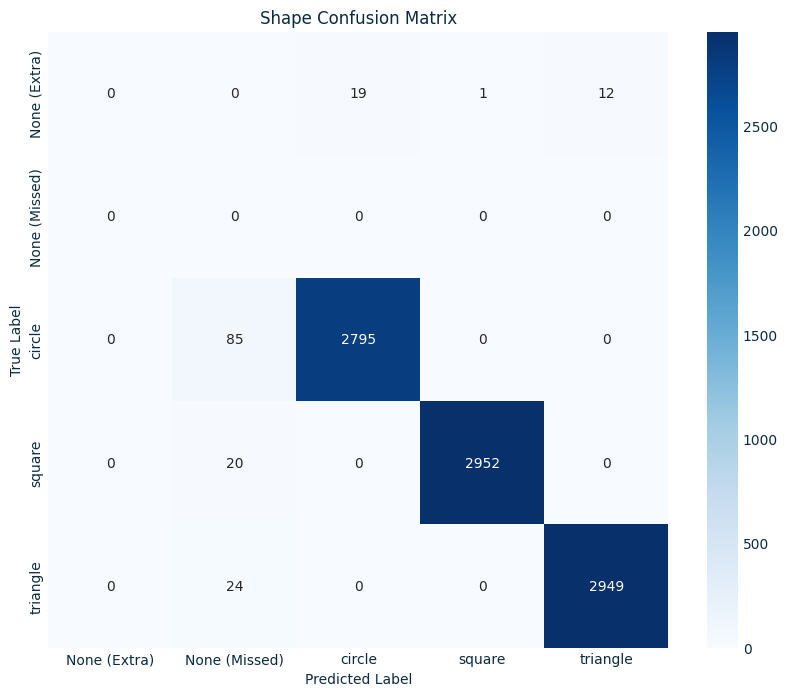


--- Generating Color Confusion Matrix ---


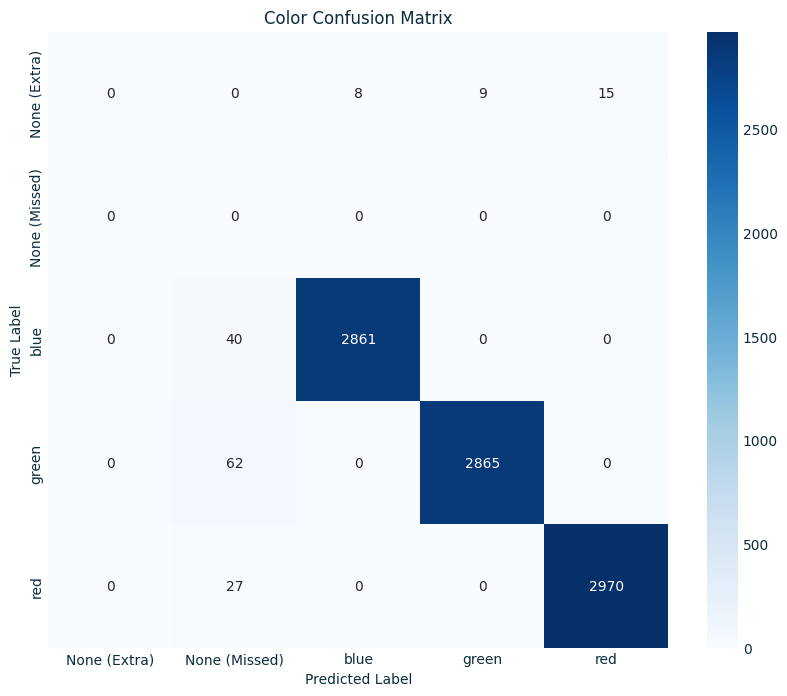

In [43]:
an.plot_confusion_matrix(true_labels_corrected, preds_corrected, analysis_type='shape')
an.plot_confusion_matrix(true_labels_corrected, preds_corrected, analysis_type='color')

looking at the confusion matrices:

* Drastic reduction in False Negatives (missed objects): we are only missing `129` objects now down from `2,072`.
* The total number of hallucinated object has drastically dropped to `32` from `465`.


## Notes on Jaccard score

seems like our classifier is doing really good but the Jaccard score is comparatively low. perhaps there's something wrong with it.

- looking at the jaccard_score from samples, i noticed that the jaccard score for cases where there's no object (both in the true and predicted labels), is `0`.
- this is a zero-division behavior which my custom code did not consider, i fixed it for now, however, we can rely on the sklearn jaccard_score for the rest of the experiments.
- notice the differce below between from `81.51%` to `98.99%`, when we calculate the loss for samples with no objects correctly.

In [63]:
jaccard_score(all_true, all_preds, average='samples')

/storage/work/bmr5889/.conda/envs/torch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


0.81509

In [64]:
jaccard_score(all_true, all_preds, average='samples', zero_division=1)

0.9898899999999999

## Visual Inspection of failed cases -- Hidden Object in image 1235
we can also look at some of the failed cases to better understand **WHY** the model failed.

In [72]:
# returns a list of [file_name, predicted_labels]
failed_squares = an.find_misclassified_files(main_df, true_labels_corrected, preds_corrected, target_shape='square')
print("Image : ", failed_squares[0][0], " | Predicted : ", failed_squares[0][1])  # Print the first failed square case
failed_circles = an.find_misclassified_files(main_df, true_labels_corrected, preds_corrected, target_shape='circle')
print("Image : ", failed_circles[0][0], " | Predicted : ", failed_circles[0][1])  # Print the first failed circle case
failed_triangles = an.find_misclassified_files(main_df, true_labels_corrected, preds_corrected, target_shape='triangle')
print("Image : ", failed_triangles[0][0], " | Predicted : ", failed_triangles[0][1])  # Print the first failed triangle case

--- Searching for misclassified 'square' files ---
Image :  train_dataset/img_1501.png  | Predicted :  {('circle', 'blue'), ('triangle', 'green'), ('square', 'green')}
--- Searching for misclassified 'circle' files ---
Image :  train_dataset/img_109.png  | Predicted :  {('triangle', 'green')}
--- Searching for misclassified 'triangle' files ---
Image :  train_dataset/img_1192.png  | Predicted :  {('square', 'blue'), ('triangle', 'blue'), ('square', 'green')}


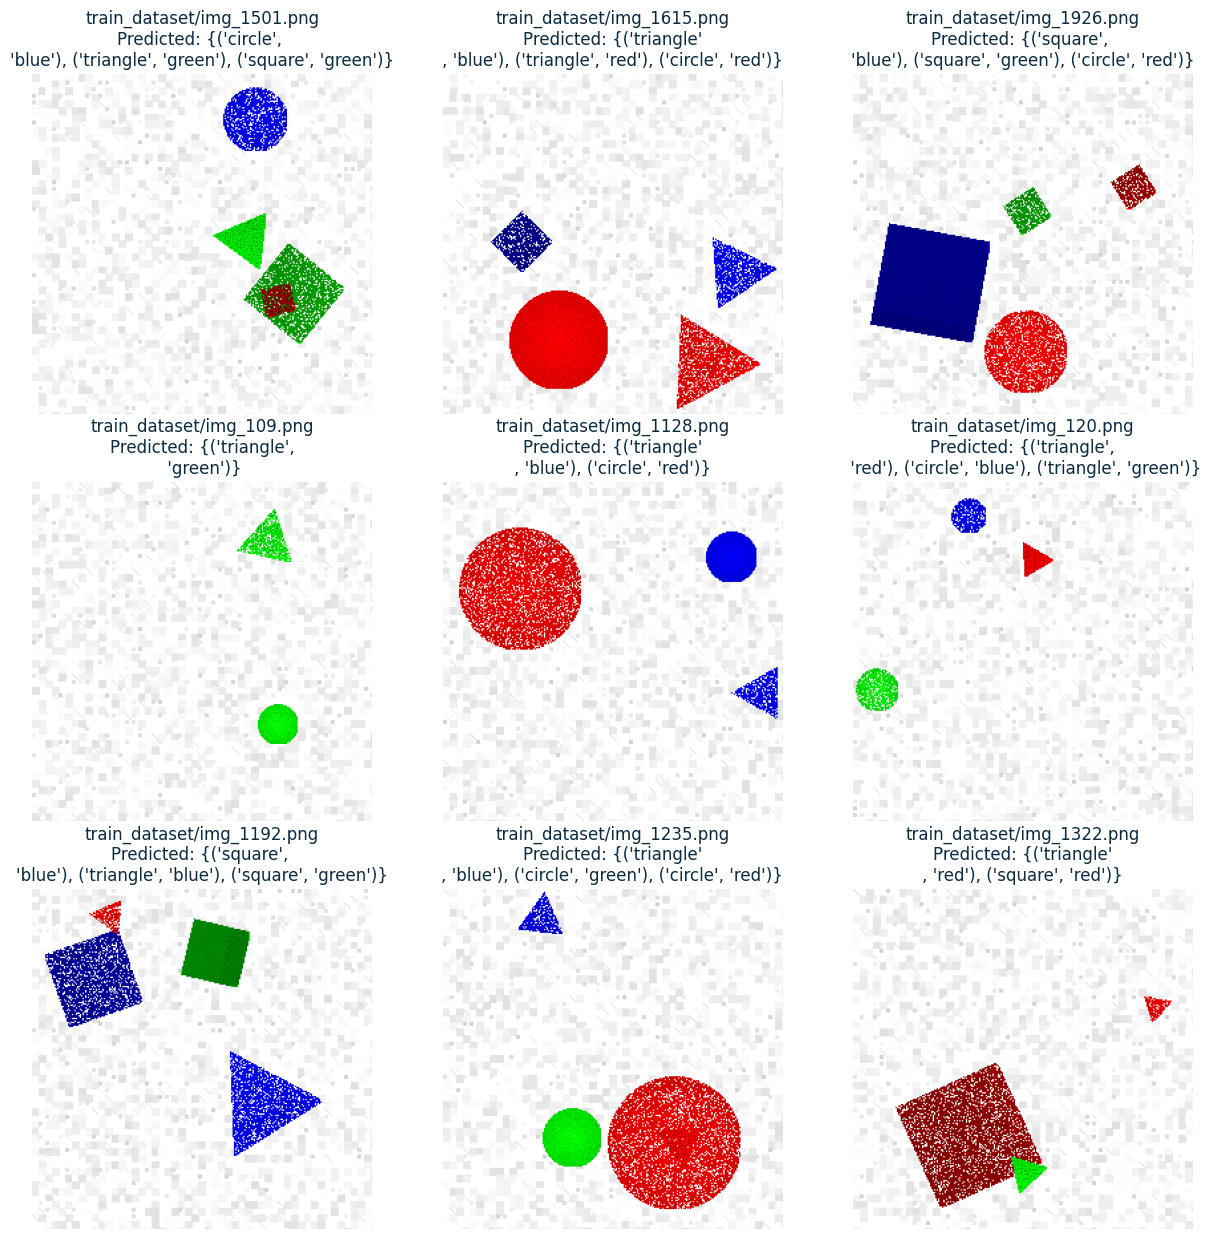

In [78]:
# let's look at some of the failed cases to better understand **WHY** the model failed.
# we will show the results in a 3x3 grid (3 rows for 3 shapes, and 3 columsn for 3 different mistakes)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for i, (ax, failed_case) in enumerate(zip(axes, failed_squares[:3] + failed_circles[:3] + failed_triangles[:3])):
    img_path = os.path.join(IMAGE_BASE_DIR, failed_case[0])
    img = Image.open(img_path)
    ax.imshow(img)
    title_text = f"{failed_case[0]}\nPredicted: {failed_case[1]}"
    if len(title_text) > 50:
        title_text = title_text[:50] + '\n' + title_text[50:]
    ax.set_title(title_text, fontsize=12)
    ax.axis('off')    

## the case of IMAGE 1235

seems like the model sometimes misses obvious objects, but there's an interesting case (`img 1235`), it looks like there's another object hidden underneath the `big red circle`.

let's dig deeper.

In [84]:
# looks like the `hidden object` is a triangle, but the color doesn't look like red, it's BLUE.?
print("image path : ", main_df.iloc[1235]['image_path'])
print("parsed labels : ", main_df.iloc[1235]['parsed_labels'])

image path :  train_dataset/img_1235.png
parsed labels :  [('circle', 'red'), ('triangle', 'blue'), ('triangle', 'red'), ('circle', 'green')]


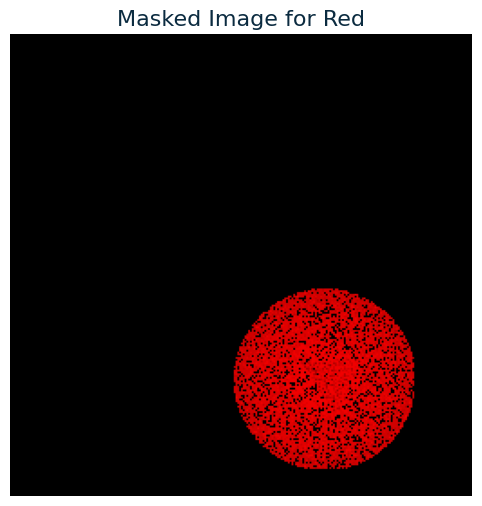

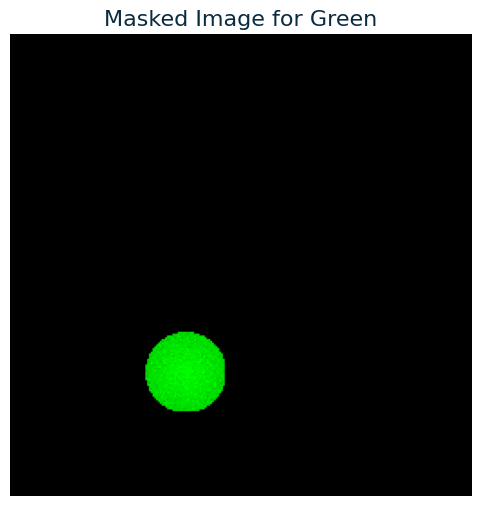

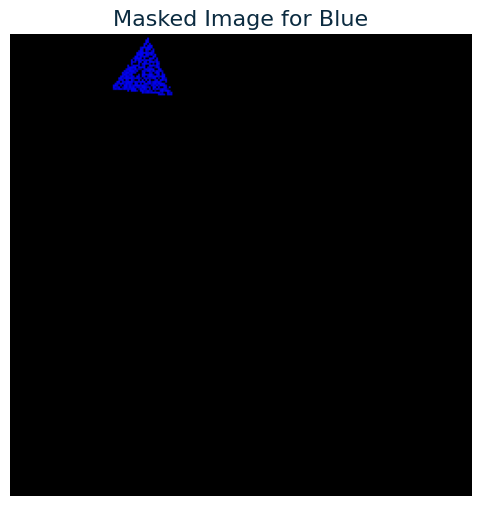

In [80]:
failed_case_path = './all-shapes-and-colors-v-2/train_dataset/img_1235.png'
img = cv2.imread(failed_case_path)

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
predictions = set()

for color, hsv_ranges in HSV_RANGES.items():
    binary_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
    if len(hsv_ranges) > 1:
        mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
        binary_mask = cv2.bitwise_or(binary_mask, mask2)
    
        
    masked_img_bgr = cv2.bitwise_and(img, img, mask=binary_mask)
    masked_img_rgb = cv2.cvtColor(masked_img_bgr, cv2.COLOR_BGR2RGB)
    
    # plot
    plt.figure(figsize=(8, 6))
    plt.imshow(masked_img_rgb)
    plt.title(f"Masked Image for {color.capitalize()}", fontsize=16)
    plt.axis('off')
    plt.show()

so yeah, basically, looks like our hidden triangle is `red`.

perhaps if we look into the dataset we will find other similar cases where an object is hidden inside another object. 

an interesting approach could be to use openCV to separate the masks? and only do shape classification using CNN.

besides seems like the default HSV range we found works well with this dataset.

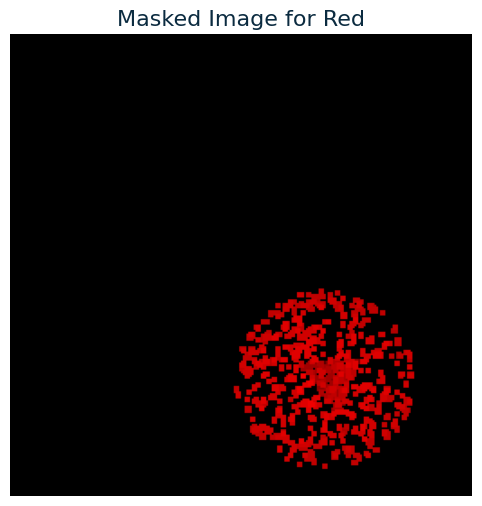

In [ ]:
failed_case_path = './all-shapes-and-colors-v-2/train_dataset/img_1235.png'
img = cv2.imread(failed_case_path)

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
predictions = set()

for color, hsv_ranges in HSV_RANGES.items():
    if color == 'red':
        binary_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
        if len(hsv_ranges) > 1:
            mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
            binary_mask = cv2.bitwise_or(binary_mask, mask2)
        
            
        masked_img_bgr = cv2.bitwise_and(img, img, mask=binary_mask)
        masked_img_rgb = cv2.cvtColor(masked_img_bgr, cv2.COLOR_BGR2RGB)
        
        # Apply morphological operations to clean up the mask
        kernel = np.ones((3, 3), np.uint8)
        masked_img_bgr = cv2.morphologyEx(masked_img_bgr, cv2.MORPH_CLOSE, kernel)
        masked_img_rgb = cv2.morphologyEx(masked_img_rgb, cv2.MORPH_OPEN, kernel)
        # plot
        plt.figure(figsize=(8, 6))
        plt.imshow(masked_img_rgb)
        plt.title(f"Masked Image for {color.capitalize()}", fontsize=16)
        plt.axis('off')
        plt.show()

yeah, looks like we got a red triangle inside the red circle.

# Hybrid openCV - CNN model

from the last analysis, we learned that a basic CNN is pretty good at doing the classification of shape and color.

we came across the `img_1235` where two objects of same color were overlapped. which was also hard to distinguish for my human eyes.

we'll add an additional channel to the CNN to help with these `hidden objects`.

True Labels:  [('circle', 'red'), ('triangle', 'blue'), ('triangle', 'red'), ('circle', 'green')]


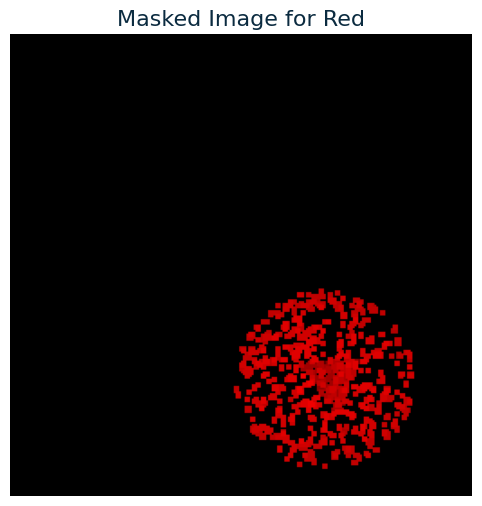

In [ ]:
# loading example failed case from previous analysis
failed_case_path = './all-shapes-and-colors-v-2/train_dataset/img_1235.png'
true_labels = main_df.iloc[1235]['parsed_labels']
print("True Labels: ", true_labels)
img = cv2.imread(failed_case_path)

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
predictions = set()

for color, hsv_ranges in HSV_RANGES.items():
    if color == 'red':
        binary_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
        if len(hsv_ranges) > 1:
            mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
            binary_mask = cv2.bitwise_or(binary_mask, mask2)
        
            
        masked_img_bgr = cv2.bitwise_and(img, img, mask=binary_mask)
        masked_img_rgb = cv2.cvtColor(masked_img_bgr, cv2.COLOR_BGR2RGB)
        
        # Apply morphological operations to clean up the mask
        kernel = np.ones((3, 3), np.uint8)
        masked_img_rgb = cv2.morphologyEx(masked_img_rgb, cv2.MORPH_OPEN, kernel)
        # plot
        plt.figure(figsize=(8, 6))
        plt.imshow(masked_img_rgb)
        plt.title(f"Masked Image for {color.capitalize()}", fontsize=16)
        plt.axis('off')
        plt.show()

In [ ]:
# Model definition and constants
SHAPE_CLASSES = ['circle', 'square', 'triangle']
SHAPE_TO_IDX = {shape: i for i, shape in enumerate(SHAPE_CLASSES)}
IDX_TO_SHAPE = {i: shape for i, shape in enumerate(SHAPE_CLASSES)}
HYBRID_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'hybrid_opencv_cnn_classifier.pth')

class MaskedShapeClassifierCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskedShapeClassifierCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 128 -> 64 -> 32 -> 16 -> 8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
# Dataset class for hybrid evaluation
class HybridEvaluationDataset(Dataset):
    """
    A dataset that returns the masked image, the color used for masking,
    and the original image path.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        # The _create_samples method from your ColorMaskDataset is perfect as is.
        self.samples = self._create_samples()

    def _create_samples(self):
        # This method is identical to the one in your ColorMaskDataset
        samples = []
        for _, row in self.df.iterrows():
            shapes_by_color = {'red': [], 'green': [], 'blue': []}
            for shape, color in row['parsed_labels']:
                shapes_by_color[color].append(shape)
            
            for color, shapes in shapes_by_color.items():
                if shapes:
                    samples.append({
                        'image_path': row['image_path'],
                        'color_to_mask': color,
                        'shapes': shapes # Kept for consistency, not used in prediction
                    })
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        color = sample['color_to_mask']
        img_path = sample['image_path']
        
        # === Image and Mask Generation (same as before) ===
        full_img_path = os.path.join(IMAGE_BASE_DIR, img_path)
        img_bgr = cv2.imread(full_img_path)
        
        hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        hsv_ranges = HSV_RANGES[color]
        binary_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
        if len(hsv_ranges) > 1:
            mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
            binary_mask = cv2.bitwise_or(binary_mask, mask2)
        
        color_masked_img = cv2.bitwise_and(img_bgr, img_bgr, mask=binary_mask)
        kernel_small = np.ones((3, 3), np.uint8)
        color_masked_img = cv2.morphologyEx(color_masked_img, cv2.MORPH_OPEN, kernel_small)
        color_masked_img = cv2.cvtColor(color_masked_img, cv2.COLOR_BGR2RGB)
        
        # === Apply Transforms ===
        if self.transform:
            pil_image = Image.fromarray(color_masked_img)
            transformed_image = self.transform(pil_image)
        
        # Return the image, color, and path
        return transformed_image, color, img_path

In [11]:
# --- New Dataset to Generate Masked Images ---
class ColorMaskDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.samples = self._create_samples()

    def _create_samples(self):
        print(f"Creating masked image samples from {len(self.df)} base images...")
        samples = []
        for _, row in self.df.iterrows():
            # Group shapes by color
            shapes_by_color = {'red': [], 'green': [], 'blue': []}
            for shape, color in row['parsed_labels']:
                shapes_by_color[color].append(shape)
            
            # For each color that has shapes, create a new training sample
            for color, shapes in shapes_by_color.items():
                if shapes:
                    samples.append({
                        'image_path': row['image_path'],
                        'color_to_mask': color,
                        'shapes': shapes
                    })
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = os.path.join(IMAGE_BASE_DIR, sample['image_path'])
        img_bgr = cv2.imread(img_path)
        
        # Generate the color mask
        hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        hsv_ranges = HSV_RANGES[sample['color_to_mask']]
        binary_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
        if len(hsv_ranges) > 1:
            mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
            binary_mask = cv2.bitwise_or(binary_mask, mask2)
        
         
        # Create the color-masked image
        color_masked_img = cv2.bitwise_and(img_bgr, img_bgr, mask=binary_mask) ## note we used the binary mask here, because we want to keep those noisey pixels, yet.
        kernel_small = np.ones((3, 3), np.uint8) # 5,5 kernel is less effective for this case
        color_masked_img = cv2.morphologyEx(color_masked_img, cv2.MORPH_OPEN, kernel_small)
        # Convert to RGB for consistency with PIL
        color_masked_img = cv2.cvtColor(color_masked_img, cv2.COLOR_BGR2RGB)
        
        
        # Create the multi-hot encoded label for shapes
        label = torch.zeros(len(SHAPE_CLASSES), dtype=torch.float32)
        for shape in sample['shapes']:
            label[SHAPE_TO_IDX[shape]] = 1
            

        # The transform needs to handle a dictionary input now
        if self.transform:
            color_masked_img = Image.fromarray(color_masked_img)
            color_masked_img = self.transform(color_masked_img)

        return color_masked_img, label

In [12]:
# Initialize the model and dataset
model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)

## -- Transformations --
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## -- Data Loaders --
train_df, val_df = train_test_split(main_df, test_size=0.2, random_state=42)

train_dataset = ColorMaskDataset(train_df, transform=train_transforms)
val_dataset = ColorMaskDataset(val_df, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Creating masked image samples from 4000 base images...
Creating masked image samples from 1000 base images...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.2752102].


Total patches extracted: 5736


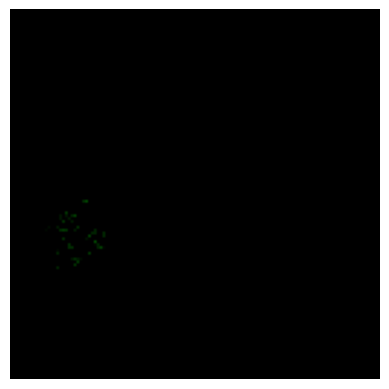

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].


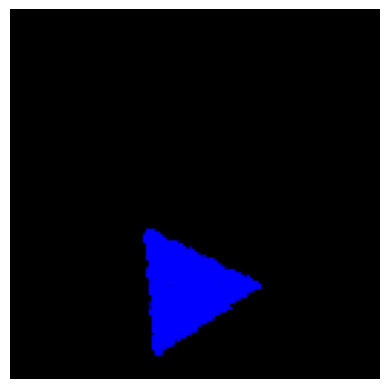

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.9131775].


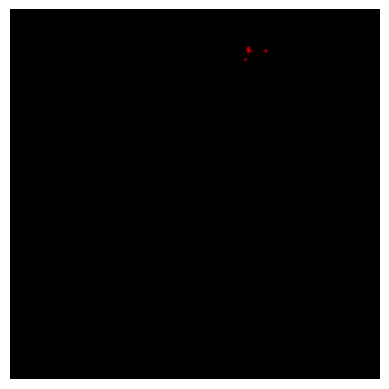

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.42649257].


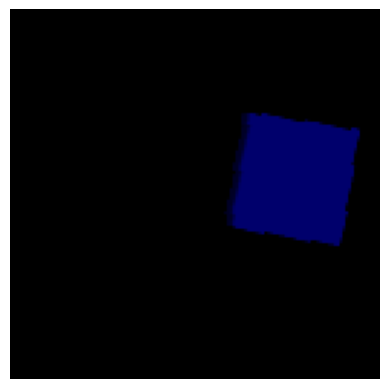

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.45080918].


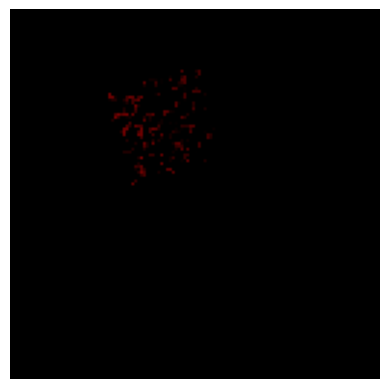

In [11]:
# let's look at the data from the patch dataset
print(f"Total patches extracted: {len(train_dataset)}")
import matplotlib.pyplot as plt
# show the first few patches
for i in range(min(5, len(train_dataset))):
    patch, label = train_dataset[i]
    plt.imshow(patch.permute(1, 2, 0).numpy())
    # plt.title(f"Label: {IDX_TO_SHAPE[label]}")
    plt.axis('off')
    plt.show()
    

In [ ]:
train_model(main_df, model, train_loader, val_loader, evaluate=False, pretrained_weights=None)

Epoch 1/30: 100%|██████████| 180/180 [00:24<00:00,  7.41it/s]


Epoch 1 Training Loss: 0.5384
Validation EMR: 0.7030 | Jaccard: 0.8104 | F1: 0.8473 | Precision: 0.9050 | Recall: 0.8258
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.8473


Epoch 2/30: 100%|██████████| 180/180 [00:22<00:00,  7.84it/s]


Epoch 2 Training Loss: 0.2959
Validation EMR: 0.8182 | Jaccard: 0.8906 | F1: 0.9137 | Precision: 0.9491 | Recall: 0.8998
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9137


Epoch 3/30: 100%|██████████| 180/180 [00:24<00:00,  7.44it/s]


Epoch 3 Training Loss: 0.1935
Validation EMR: 0.8452 | Jaccard: 0.9090 | F1: 0.9284 | Precision: 0.9327 | Recall: 0.9395
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9284


Epoch 4/30: 100%|██████████| 180/180 [00:23<00:00,  7.80it/s]


Epoch 4 Training Loss: 0.1707
Validation EMR: 0.8799 | Jaccard: 0.9318 | F1: 0.9475 | Precision: 0.9477 | Recall: 0.9600
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9475


Epoch 5/30: 100%|██████████| 180/180 [00:23<00:00,  7.77it/s]


Epoch 5 Training Loss: 0.1064
Validation EMR: 0.9500 | Jaccard: 0.9725 | F1: 0.9794 | Precision: 0.9864 | Recall: 0.9785
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9794


Epoch 6/30: 100%|██████████| 180/180 [00:25<00:00,  7.15it/s]


Epoch 6 Training Loss: 0.0892
Validation EMR: 0.9445 | Jaccard: 0.9656 | F1: 0.9723 | Precision: 0.9832 | Recall: 0.9672


Epoch 7/30: 100%|██████████| 180/180 [00:22<00:00,  7.88it/s]


Epoch 7 Training Loss: 0.0836
Validation EMR: 0.9486 | Jaccard: 0.9692 | F1: 0.9756 | Precision: 0.9799 | Recall: 0.9769


Epoch 8/30: 100%|██████████| 180/180 [00:22<00:00,  8.11it/s]


Epoch 8 Training Loss: 0.0664
Validation EMR: 0.9445 | Jaccard: 0.9653 | F1: 0.9718 | Precision: 0.9769 | Recall: 0.9720


Epoch 9/30: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Epoch 9 Training Loss: 0.0689
Validation EMR: 0.9389 | Jaccard: 0.9609 | F1: 0.9679 | Precision: 0.9734 | Recall: 0.9683


Epoch 10/30: 100%|██████████| 180/180 [00:24<00:00,  7.42it/s]


Epoch 10 Training Loss: 0.0547
Validation EMR: 0.9750 | Jaccard: 0.9861 | F1: 0.9893 | Precision: 0.9923 | Recall: 0.9890
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9893


Epoch 11/30: 100%|██████████| 180/180 [00:23<00:00,  7.75it/s]


Epoch 11 Training Loss: 0.0553
Validation EMR: 0.9729 | Jaccard: 0.9840 | F1: 0.9875 | Precision: 0.9909 | Recall: 0.9872


Epoch 12/30: 100%|██████████| 180/180 [00:22<00:00,  7.88it/s]


Epoch 12 Training Loss: 0.0507
Validation EMR: 0.9591 | Jaccard: 0.9727 | F1: 0.9771 | Precision: 0.9854 | Recall: 0.9732


Epoch 13/30: 100%|██████████| 180/180 [00:22<00:00,  7.89it/s]


Epoch 13 Training Loss: 0.0453
Validation EMR: 0.9514 | Jaccard: 0.9733 | F1: 0.9798 | Precision: 0.9894 | Recall: 0.9763


Epoch 14/30: 100%|██████████| 180/180 [00:22<00:00,  8.02it/s]


Epoch 14 Training Loss: 0.0424
Validation EMR: 0.9764 | Jaccard: 0.9858 | F1: 0.9887 | Precision: 0.9921 | Recall: 0.9879


Epoch 15/30: 100%|██████████| 180/180 [00:23<00:00,  7.82it/s]


Epoch 15 Training Loss: 0.1563
Validation EMR: 0.9480 | Jaccard: 0.9685 | F1: 0.9752 | Precision: 0.9828 | Recall: 0.9735


Epoch 16/30: 100%|██████████| 180/180 [00:22<00:00,  7.89it/s]


Epoch 16 Training Loss: 0.0609
Validation EMR: 0.9563 | Jaccard: 0.9729 | F1: 0.9779 | Precision: 0.9810 | Recall: 0.9792


Epoch 17/30: 100%|██████████| 180/180 [00:22<00:00,  7.85it/s]


Epoch 17 Training Loss: 0.0504
Validation EMR: 0.9598 | Jaccard: 0.9771 | F1: 0.9823 | Precision: 0.9842 | Recall: 0.9851


Epoch 18/30: 100%|██████████| 180/180 [00:22<00:00,  7.91it/s]


Epoch 18 Training Loss: 0.0517
Validation EMR: 0.9695 | Jaccard: 0.9820 | F1: 0.9857 | Precision: 0.9881 | Recall: 0.9865


Epoch 19/30: 100%|██████████| 180/180 [00:22<00:00,  7.89it/s]


Epoch 19 Training Loss: 0.0430
Validation EMR: 0.9632 | Jaccard: 0.9786 | F1: 0.9832 | Precision: 0.9866 | Recall: 0.9832


Epoch 20/30: 100%|██████████| 180/180 [00:22<00:00,  7.85it/s]


Epoch 20 Training Loss: 0.0396
Validation EMR: 0.9695 | Jaccard: 0.9832 | F1: 0.9873 | Precision: 0.9916 | Recall: 0.9866


Epoch 21/30: 100%|██████████| 180/180 [00:22<00:00,  7.92it/s]


Epoch 21 Training Loss: 0.0328
Validation EMR: 0.9736 | Jaccard: 0.9859 | F1: 0.9895 | Precision: 0.9916 | Recall: 0.9904
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9895


Epoch 22/30: 100%|██████████| 180/180 [00:22<00:00,  7.93it/s]


Epoch 22 Training Loss: 0.0517
Validation EMR: 0.9743 | Jaccard: 0.9860 | F1: 0.9896 | Precision: 0.9933 | Recall: 0.9890
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9896


Epoch 23/30: 100%|██████████| 180/180 [00:22<00:00,  8.00it/s]


Epoch 23 Training Loss: 0.0301
Validation EMR: 0.9806 | Jaccard: 0.9891 | F1: 0.9916 | Precision: 0.9950 | Recall: 0.9904
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9916


Epoch 24/30: 100%|██████████| 180/180 [00:22<00:00,  7.96it/s]


Epoch 24 Training Loss: 0.0305
Validation EMR: 0.9820 | Jaccard: 0.9907 | F1: 0.9934 | Precision: 0.9961 | Recall: 0.9931
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9934


Epoch 25/30: 100%|██████████| 180/180 [00:22<00:00,  7.86it/s]


Epoch 25 Training Loss: 0.0312
Validation EMR: 0.9715 | Jaccard: 0.9842 | F1: 0.9879 | Precision: 0.9906 | Recall: 0.9884


Epoch 26/30: 100%|██████████| 180/180 [00:22<00:00,  8.00it/s]


Epoch 26 Training Loss: 0.0310
Validation EMR: 0.9695 | Jaccard: 0.9817 | F1: 0.9852 | Precision: 0.9857 | Recall: 0.9875


Epoch 27/30: 100%|██████████| 180/180 [00:23<00:00,  7.81it/s]


Epoch 27 Training Loss: 0.0355
Validation EMR: 0.9618 | Jaccard: 0.9784 | F1: 0.9833 | Precision: 0.9864 | Recall: 0.9846


Epoch 28/30: 100%|██████████| 180/180 [00:23<00:00,  7.78it/s]


Epoch 28 Training Loss: 0.0233
Validation EMR: 0.9806 | Jaccard: 0.9885 | F1: 0.9911 | Precision: 0.9946 | Recall: 0.9898


Epoch 29/30: 100%|██████████| 180/180 [00:22<00:00,  7.96it/s]


Epoch 29 Training Loss: 0.0308
Validation EMR: 0.9868 | Jaccard: 0.9933 | F1: 0.9950 | Precision: 0.9964 | Recall: 0.9948
-> New best model saved to ./saved_models/best_simple_cnn.pth with F1 score: 0.9950


Epoch 30/30: 100%|██████████| 180/180 [00:22<00:00,  7.95it/s]


Epoch 30 Training Loss: 0.0247
Validation EMR: 0.9660 | Jaccard: 0.9800 | F1: 0.9844 | Precision: 0.9885 | Recall: 0.9833


looks like the changes we made to the data itself improved the model's performance as follows:

- EMR improved by `10.68%` from 88.00% to 98.68%
- Jaccard improved by `16%` from 82.00% to 98.00%
- F1 score improved by `18.59%` from 79.85% to 98.44%
- Precision improved by `17.29%` from 81.56% to 98.85%
- Recall improved by `19.33%` from 79.00% to 98.33%

In [14]:

print("\n--- Evaluating Best Hybrid Pipeline ---")
model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, "best_simple_cnn.pth"), map_location=DEVICE))

## -- Transformations --
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


hybrid_preds = []
for _, row in tqdm(main_df.iterrows(), total=len(main_df), desc="Hybrid Pipeline Evaluation"):
    full_path = os.path.join(IMAGE_BASE_DIR, row['image_path'])
    hybrid_preds.append(get_hybrid_predictions(full_path, model, val_transforms))


--- Evaluating Best Hybrid Pipeline ---


Hybrid Pipeline Evaluation: 100%|██████████| 5000/5000 [00:39<00:00, 126.74it/s]


In [28]:
an.compare_object_counts(main_df['parsed_labels'], hybrid_preds)

--- Object Count Comparison ---
 Num Objects  True Count  Predicted Count  Difference
           0         874              874           0
           1        1228             1234           6
           2        1479             1483           4
           3        1069             1064          -5
           4         318              312          -6
           5          32               32           0
           6           0                1           1



--- Generating Shape Confusion Matrix ---


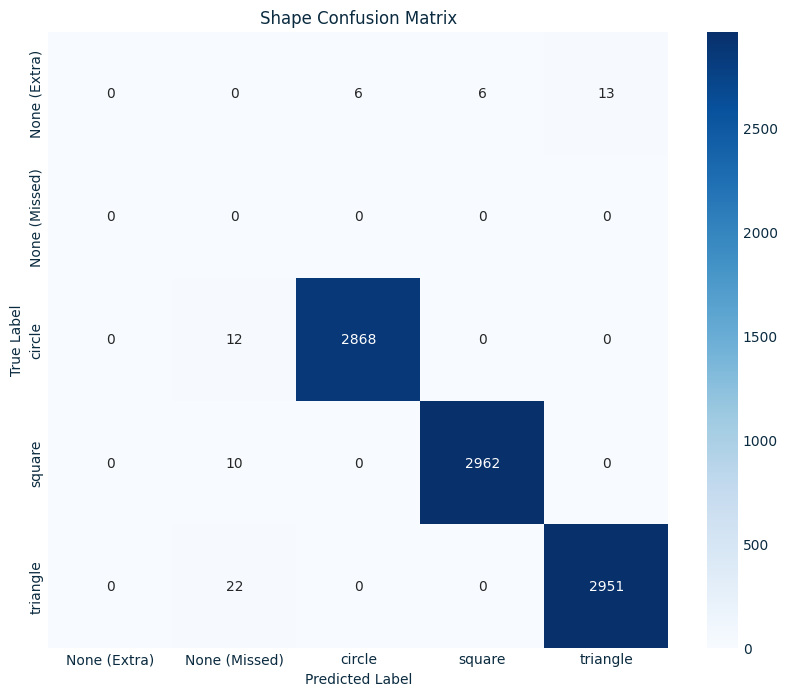


--- Generating Color Confusion Matrix ---


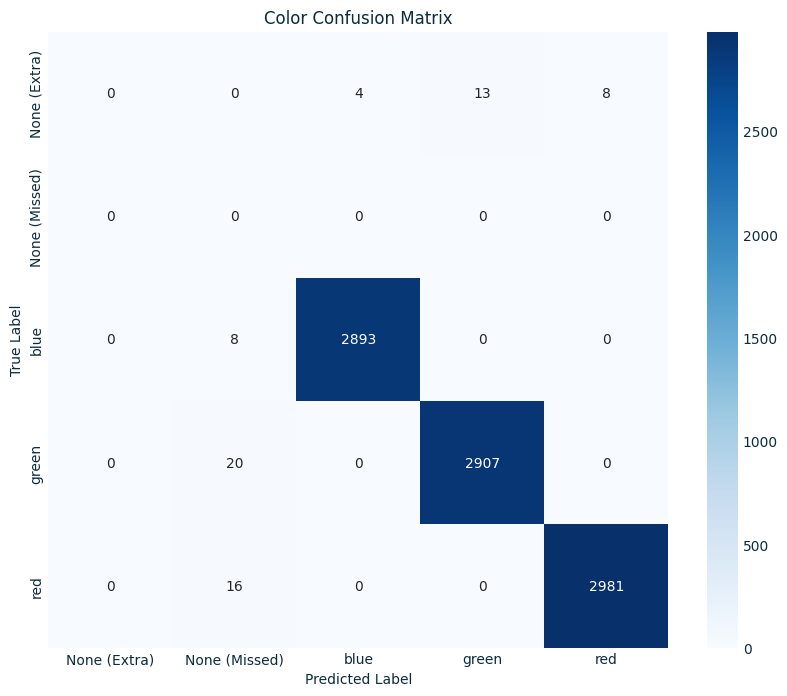

In [29]:
an.plot_confusion_matrix(main_df['label_set'], hybrid_preds, analysis_type='shape')
an.plot_confusion_matrix(main_df['label_set'], hybrid_preds, analysis_type='color')

In [ ]:
hybrid_preds_multi_hot = []
for preds in hybrid_preds:
    hybrid_preds_multi_hot.append(convert_to_multi_hot(preds, ALL_CLASSES))
hybrid_preds_multi_hot = np.array(hybrid_preds_multi_hot)


true_labels_multi_hot = []
for labels in main_df['parsed_labels']:
    true_labels_multi_hot.append(convert_to_multi_hot(labels, ALL_CLASSES))
true_labels_multi_hot = np.array(true_labels_multi_hot)

jac_score = jaccard_score(true_labels_multi_hot, hybrid_preds_multi_hot, average='samples', zero_division=1)
print(f"Jaccard Score for Hybrid Model: {jac_score:.4f}")

Jaccard Score for Hybrid Model: 0.9959


In [16]:
# get the last convolutional layer of the model (before flatting)
last_conv_layer = model.features[-4]

In [ ]:
# Generate feature maps using GradCAM to identify failures
from analysis import analyze_hybrid_model_failures
analyze_hybrid_model_failures(model, last_conv_layer, val_df, get_hybrid_predictions, val_transforms,
    HSV_RANGES, SHAPE_TO_IDX, IDX_TO_SHAPE, IMAGE_BASE_DIR, './analysis_results/hybrid_cnn_failures/', DEVICE)

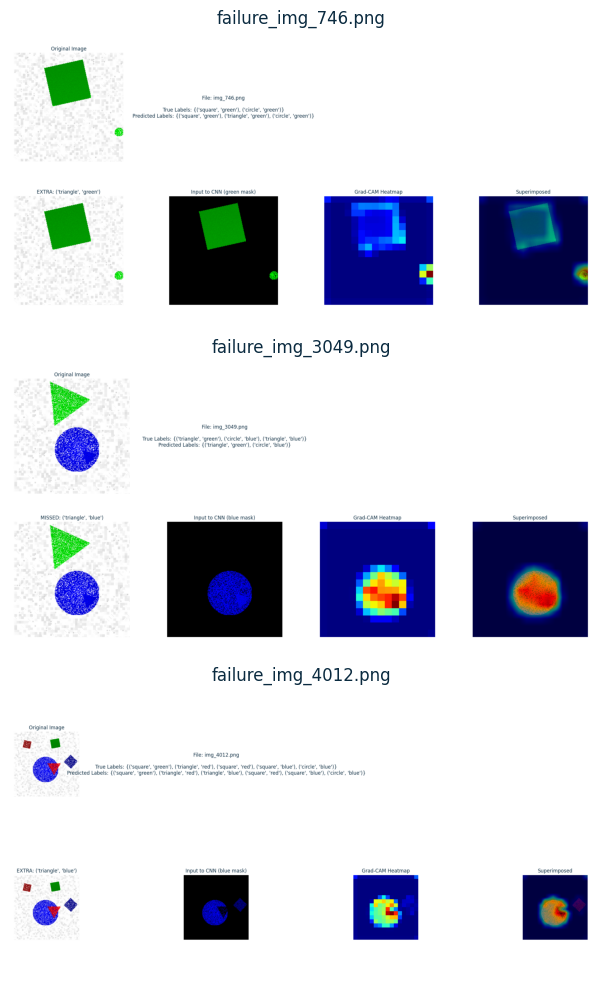

In [12]:
# let's look at some of the failed cases to better understand **WHY** the model failed.
hybrid_CNN_failures = './analysis_results/hybrid_cnn_failures/'
images = os.listdir(hybrid_CNN_failures)
selected_images = ['failure_img_746.png', 'failure_img_3049.png', 'failure_img_4012.png']
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i >= len(selected_images):
        break
    img_path = os.path.join(hybrid_CNN_failures, selected_images[i])
    img = Image.open(img_path)
    ax.imshow(img)
    title_text = f"{selected_images[i]}"
    if len(title_text) > 50:
        title_text = title_text[:50] + '\n' + title_text[50:]
    ax.set_title(title_text, fontsize=12)
    ax.axis('off')
    plt.tight_layout()
# plt.close()

Spurios relations: when searching for `triangle` the model appears to have learned fictional relationship between the spatial arrangement of the objects, this is also visible in the **image 4012** where the model sees a blue triangle, perhaps because of the mark the other triangle has left.
--> to summarize; the model has a poor object-level understanding. it hallucinates shapes by incorrectly combining features from completely separate objects, whether they are close together or far apart.

Additionally, the model is still unable to identify shapes where the shape's features are subtle or must compete with another pattern (like missing the triangle within a circle). it needs to learn more flexible and resilient features.

Lastly, the model's poor object-level understanding also leads to cases where it misses objects that are too close to each other.

In [181]:
# returns a list of [file_name, predicted_labels]
failed_squares = an.find_misclassified_files(main_df, true_labels_corrected, preds_corrected, target_shape='square')
print("Image : ", failed_squares[0][0], " | Predicted : ", failed_squares[0][1])  # Print the first failed square case
failed_circles = an.find_misclassified_files(main_df, true_labels_corrected, preds_corrected, target_shape='circle')
print("Image : ", failed_circles[0][0], " | Predicted : ", failed_circles[0][1])  # Print the first failed circle case
failed_triangles = an.find_misclassified_files(main_df, true_labels_corrected, preds_corrected, target_shape='triangle')
print("Image : ", failed_triangles[0][0], " | Predicted : ", failed_triangles[0][1])  # Print the first failed triangle case"

--- Searching for misclassified 'square' files ---
Image :  train_dataset/img_1221.png  | Predicted :  {('triangle', 'blue')}
--- Searching for misclassified 'circle' files ---
Image :  train_dataset/img_1613.png  | Predicted :  {('triangle', 'blue')}
--- Searching for misclassified 'triangle' files ---
Image :  train_dataset/img_1706.png  | Predicted :  {('circle', 'blue')}


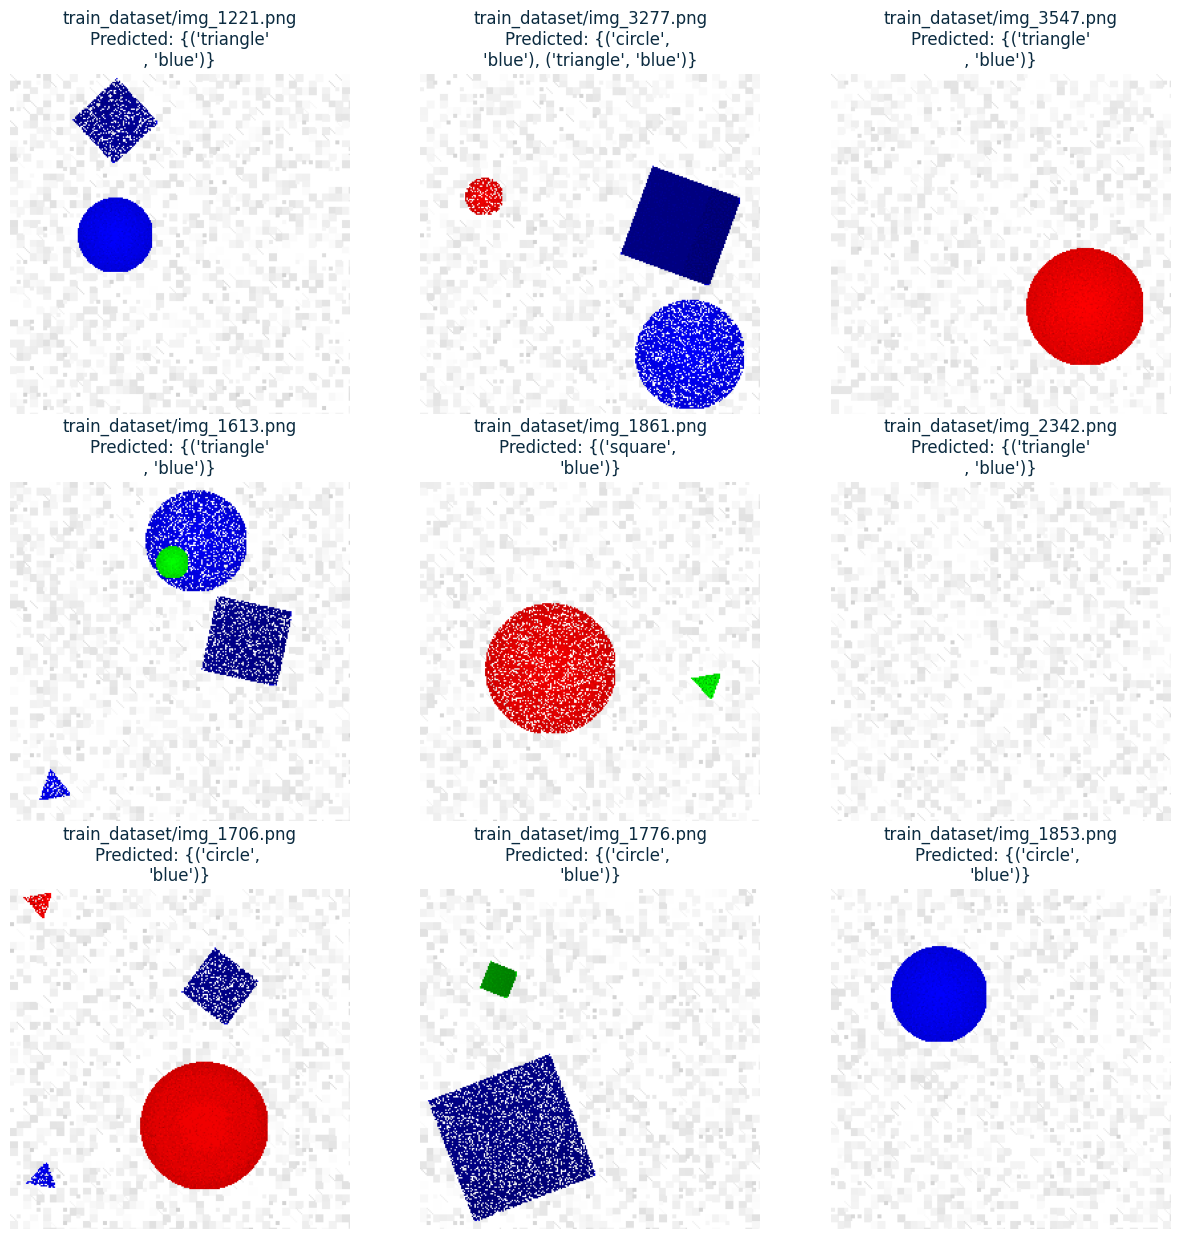

In [182]:
# let's look at some of the failed cases to better understand **WHY** the model failed.
# we will show the results in a 3x3 grid (3 rows for 3 shapes, and 3 columsn for 3 different mistakes)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for i, (ax, failed_case) in enumerate(zip(axes, failed_squares[:3] + failed_circles[:3] + failed_triangles[:3])):
    img_path = os.path.join(IMAGE_BASE_DIR, failed_case[0])
    img = Image.open(img_path)
    ax.imshow(img)
    title_text = f"{failed_case[0]}\nPredicted: {failed_case[1]}"
    if len(title_text) > 50:
        title_text = title_text[:50] + '\n' + title_text[50:]
    ax.set_title(title_text, fontsize=12)
    ax.axis('off')    

### evaluating the model with stratifiedKfold cross-validation

In [13]:
from sklearn.model_selection import StratifiedKFold

main_df['num_objects'] = main_df['parsed_labels'].apply(len)
kfold_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
fold_scores = []
    
for fold, (train_idx, val_idx) in enumerate(kfold_strat.split(main_df, main_df['num_objects'])):
    print(f"\n--- Training Fold {fold + 1} ---")
    train_df = main_df.iloc[train_idx].reset_index(drop=True)
    val_df = main_df.iloc[val_idx].reset_index(drop=True)

    # Initialize the model
    model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
    fold_model_path = f'cnn_hybrid_masked_shape_classifier_{fold+1}.pth'
    
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

    # Create datasets and loaders    
    train_dataset = ColorMaskDataset(train_df, transform=train_transforms)
    val_dataset = ColorMaskDataset(val_df, transform=val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Train the model
    train_model(main_df, model, train_loader, save_name=fold_model_path, val_loader=val_loader, evaluate=False)
    
    # Evaluate the model
    print(f"\nEvaluating best model for Fold {fold+1}...")
    best_fold_model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
    best_fold_model.load_state_dict(torch.load(MODEL_SAVE_DIR + fold_model_path))
    
    fold_hybrid_preds = []
    for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc=f"Fold {fold+1} Final Eval", miniters=200):
        fold_hybrid_preds.append(get_hybrid_predictions(full_path, best_fold_model))

    true_labels_list = val_df['parsed_labels'].apply(lambda x: sorted(list(x))).tolist()
    
    # Calculate Jaccard score for this fold
    emr, jac_score = evaluate_predictions(true_labels_list, fold_hybrid_preds)
    fold_scores.append(jac_score)
    print(f"Fold {fold + 1} Jaccard Score: {jac_score:.4f} | EMR: {emr:.4f}")

## Training on full dataset

In [15]:
# train the model on all training data
print("\n--- Training Final Model on Full Dataset ---")
final_model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
final_train_dataset = ColorMaskDataset(main_df, transform=train_transforms)
final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_model(main_df, final_model, final_train_loader, val_loader, save_name='final_hybrid_masked_shape_classifier.pth', evaluate=False)

# Evaluate the final model on the full dataset
print("\n--- Evaluating Final Model on Full Dataset ---")
final_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, "final_hybrid_masked_shape_classifier.pth"), map_location=DEVICE))
final_hybrid_preds = []
for _, row in tqdm(main_df.iterrows(), total=len(main_df), desc="Final Model Evaluation"):
    final_hybrid_preds.append(get_hybrid_predictions(row['image_path'], final_model, val_transforms))
true_labels_list = main_df['parsed_labels'].apply(lambda x: sorted(list(x))).tolist()
emr, final_jac_score = evaluate_predictions(true_labels_list, final_hybrid_preds)
print(f"Final Model Jaccard Score: {final_jac_score:.4f} | EMR: {emr:.4f}")


--- Training Final Model on Full Dataset ---
Creating masked image samples from 5000 base images...


Epoch 1/30: 100%|██████████| 225/225 [00:32<00:00,  6.87it/s]


Epoch 1 Training Loss: 0.5129
Validation EMR: 0.6690 | Jaccard: 0.7858 | F1: 0.8255 | Precision: 0.8718 | Recall: 0.8180
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.8255


Epoch 2/30: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


Epoch 2 Training Loss: 0.2362
Validation EMR: 0.8862 | Jaccard: 0.9353 | F1: 0.9517 | Precision: 0.9809 | Recall: 0.9385
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9517


Epoch 3/30: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]


Epoch 3 Training Loss: 0.1293
Validation EMR: 0.9549 | Jaccard: 0.9763 | F1: 0.9832 | Precision: 0.9905 | Recall: 0.9821
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9832


Epoch 4/30: 100%|██████████| 225/225 [00:41<00:00,  5.48it/s]


Epoch 4 Training Loss: 0.0890
Validation EMR: 0.9757 | Jaccard: 0.9868 | F1: 0.9901 | Precision: 0.9950 | Recall: 0.9881
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9901


Epoch 5/30: 100%|██████████| 225/225 [00:42<00:00,  5.34it/s]


Epoch 5 Training Loss: 0.0631
Validation EMR: 0.9667 | Jaccard: 0.9831 | F1: 0.9878 | Precision: 0.9870 | Recall: 0.9924


Epoch 6/30: 100%|██████████| 225/225 [00:35<00:00,  6.38it/s]


Epoch 6 Training Loss: 0.0603
Validation EMR: 0.9681 | Jaccard: 0.9795 | F1: 0.9833 | Precision: 0.9864 | Recall: 0.9837


Epoch 7/30: 100%|██████████| 225/225 [00:50<00:00,  4.50it/s]


Epoch 7 Training Loss: 0.0614
Validation EMR: 0.9868 | Jaccard: 0.9926 | F1: 0.9942 | Precision: 0.9961 | Recall: 0.9938
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9942


Epoch 8/30: 100%|██████████| 225/225 [00:36<00:00,  6.23it/s]


Epoch 8 Training Loss: 0.0447
Validation EMR: 0.9882 | Jaccard: 0.9935 | F1: 0.9950 | Precision: 0.9965 | Recall: 0.9949
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9950


Epoch 9/30: 100%|██████████| 225/225 [00:34<00:00,  6.46it/s]


Epoch 9 Training Loss: 0.0605
Validation EMR: 0.9827 | Jaccard: 0.9895 | F1: 0.9914 | Precision: 0.9919 | Recall: 0.9925


Epoch 10/30: 100%|██████████| 225/225 [00:33<00:00,  6.70it/s]


Epoch 10 Training Loss: 0.0504
Validation EMR: 0.9868 | Jaccard: 0.9919 | F1: 0.9935 | Precision: 0.9944 | Recall: 0.9938


Epoch 11/30: 100%|██████████| 225/225 [00:35<00:00,  6.37it/s]


Epoch 11 Training Loss: 0.0445
Validation EMR: 0.9785 | Jaccard: 0.9874 | F1: 0.9901 | Precision: 0.9941 | Recall: 0.9884


Epoch 12/30: 100%|██████████| 225/225 [00:37<00:00,  6.03it/s]


Epoch 12 Training Loss: 0.0358
Validation EMR: 0.9931 | Jaccard: 0.9957 | F1: 0.9965 | Precision: 0.9975 | Recall: 0.9962
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9965


Epoch 13/30: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]


Epoch 13 Training Loss: 0.0519
Validation EMR: 0.9889 | Jaccard: 0.9942 | F1: 0.9957 | Precision: 0.9969 | Recall: 0.9960


Epoch 14/30: 100%|██████████| 225/225 [00:40<00:00,  5.52it/s]


Epoch 14 Training Loss: 0.0317
Validation EMR: 0.9840 | Jaccard: 0.9909 | F1: 0.9930 | Precision: 0.9962 | Recall: 0.9917


Epoch 15/30: 100%|██████████| 225/225 [00:34<00:00,  6.59it/s]


Epoch 15 Training Loss: 0.0346
Validation EMR: 0.9695 | Jaccard: 0.9823 | F1: 0.9864 | Precision: 0.9938 | Recall: 0.9830


Epoch 16/30: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]


Epoch 16 Training Loss: 0.0332
Validation EMR: 0.9910 | Jaccard: 0.9951 | F1: 0.9965 | Precision: 0.9970 | Recall: 0.9972
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9965


Epoch 17/30: 100%|██████████| 225/225 [00:38<00:00,  5.86it/s]


Epoch 17 Training Loss: 0.0259
Validation EMR: 0.9917 | Jaccard: 0.9946 | F1: 0.9955 | Precision: 0.9966 | Recall: 0.9951


Epoch 18/30: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


Epoch 18 Training Loss: 0.0252
Validation EMR: 0.9840 | Jaccard: 0.9901 | F1: 0.9920 | Precision: 0.9926 | Recall: 0.9931


Epoch 19/30: 100%|██████████| 225/225 [00:32<00:00,  6.99it/s]


Epoch 19 Training Loss: 0.0314
Validation EMR: 0.9847 | Jaccard: 0.9925 | F1: 0.9946 | Precision: 0.9938 | Recall: 0.9973


Epoch 20/30: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]


Epoch 20 Training Loss: 0.0294
Validation EMR: 0.9910 | Jaccard: 0.9946 | F1: 0.9957 | Precision: 0.9965 | Recall: 0.9960


Epoch 21/30: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


Epoch 21 Training Loss: 0.0266
Validation EMR: 0.9931 | Jaccard: 0.9958 | F1: 0.9968 | Precision: 0.9979 | Recall: 0.9965
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9968


Epoch 22/30: 100%|██████████| 225/225 [00:33<00:00,  6.77it/s]


Epoch 22 Training Loss: 0.0319
Validation EMR: 0.9924 | Jaccard: 0.9960 | F1: 0.9971 | Precision: 0.9990 | Recall: 0.9963
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9971


Epoch 23/30: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]


Epoch 23 Training Loss: 0.0219
Validation EMR: 0.9917 | Jaccard: 0.9948 | F1: 0.9958 | Precision: 0.9970 | Recall: 0.9955


Epoch 24/30: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


Epoch 24 Training Loss: 0.0228
Validation EMR: 0.9944 | Jaccard: 0.9966 | F1: 0.9973 | Precision: 0.9984 | Recall: 0.9969
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9973


Epoch 25/30: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]


Epoch 25 Training Loss: 0.0306
Validation EMR: 0.9958 | Jaccard: 0.9977 | F1: 0.9982 | Precision: 0.9991 | Recall: 0.9979
-> New best model saved to ./saved_models/final_hybrid_masked_shape_classifier.pth with F1 score: 0.9982


Epoch 26/30: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]


Epoch 26 Training Loss: 0.0192
Validation EMR: 0.9958 | Jaccard: 0.9973 | F1: 0.9978 | Precision: 0.9984 | Recall: 0.9976


Epoch 27/30: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]


Epoch 27 Training Loss: 0.0273
Validation EMR: 0.9951 | Jaccard: 0.9969 | F1: 0.9975 | Precision: 0.9986 | Recall: 0.9969


Epoch 28/30: 100%|██████████| 225/225 [00:31<00:00,  7.26it/s]


Epoch 28 Training Loss: 0.0300
Validation EMR: 0.9917 | Jaccard: 0.9950 | F1: 0.9962 | Precision: 0.9972 | Recall: 0.9962


Epoch 29/30: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]


Epoch 29 Training Loss: 0.0320
Validation EMR: 0.9514 | Jaccard: 0.9683 | F1: 0.9736 | Precision: 0.9835 | Recall: 0.9687


Epoch 30/30: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


Epoch 30 Training Loss: 0.1018
Validation EMR: 0.9896 | Jaccard: 0.9947 | F1: 0.9963 | Precision: 0.9991 | Recall: 0.9949

--- Evaluating Final Model on Full Dataset ---


Final Model Evaluation:   0%|          | 0/5000 [00:00<?, ?it/s][ WARN:0@1535.719] global loadsave.cpp:275 findDecoder imread_('train_dataset/img_0.png'): can't open/read file: check file path/integrity
[ WARN:0@1535.720] global loadsave.cpp:275 findDecoder imread_('train_dataset/img_1.png'): can't open/read file: check file path/integrity
[ WARN:0@1535.721] global loadsave.cpp:275 findDecoder imread_('train_dataset/img_2.png'): can't open/read file: check file path/integrity
[ WARN:0@1535.721] global loadsave.cpp:275 findDecoder imread_('train_dataset/img_3.png'): can't open/read file: check file path/integrity
[ WARN:0@1535.721] global loadsave.cpp:275 findDecoder imread_('train_dataset/img_4.png'): can't open/read file: check file path/integrity
[ WARN:0@1535.722] global loadsave.cpp:275 findDecoder imread_('train_dataset/img_5.png'): can't open/read file: check file path/integrity
[ WARN:0@1535.722] global loadsave.cpp:275 findDecoder imread_('train_dataset/img_6.png'): can't open/

Final Model Jaccard Score: 0.1748 | EMR: 0.1748


## Predicting for Kaggle submission

In [17]:
# now let's test it on the test set
test_df = pd.read_csv('./all-shapes-and-colors-v-2/test.csv')
ANALYSIS_OUTPUT_DIR = './all-shapes-and-colors-v-2/analysis/'

hybrid_model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
hybrid_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, "final_hybrid_masked_shape_classifier.pth"), map_location=DEVICE))
test_preds = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Hybrid Pipeline Evaluation on Test Set"):
        full_path = os.path.join(IMAGE_BASE_DIR, row['image_path'])
        test_preds.append(get_hybrid_predictions(full_path, hybrid_model, val_transforms))
        
# Save test predictions
test_df['cnn_hybrid_masked_shape_predictions'] = test_preds
test_df[['image_path', 'cnn_hybrid_masked_shape_predictions']].to_csv(os.path.join(ANALYSIS_OUTPUT_DIR, 'final_cnn_hybrid_masked_shape_test_predictions.csv'), index=False)

Hybrid Pipeline Evaluation on Test Set: 100%|██████████| 1000/1000 [00:06<00:00, 150.19it/s]


# ResNetCNN-Model (Kaggle Submission)

By analyzing the results of the CNN we learned that the model tends not to fully learn the geometries, below we will train a resnet model which we use for final predictions. below is a summary of analyzing the CNN model:

* the architecture allows for learning features for smaller objects that will get lost throughout the feature extraction process, which the basic CNN model had problems with.

* additionally, we hypothesize that smaller the model the poorer its object-level understanding. which results in the model hallucinating shapes by incorrectly combining features from completely separate objects, whether they are close together or far apart.

* furthermore, the model is still unable to identify shapes where the shape's features are subtle or must compete with another pattern (like missing the triangle within a circle). it needs to learn more flexible and resilient features.

* Lastly, the model's poor object-level understanding also leads to cases where it misses objects that are too close to each other.

In [ ]:
# model definition, dataset, and transforms for the new masked image dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- New Dataset to Generate Masked Images ---
class ColorMaskDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.samples = self._create_samples()

    def _create_samples(self):
        print(f"Creating masked image samples from {len(self.df)} base images...")
        samples = []
        for _, row in self.df.iterrows():
            # Group shapes by color
            shapes_by_color = {'red': [], 'green': [], 'blue': []}
            for shape, color in row['parsed_labels']:
                shapes_by_color[color].append(shape)
            
            # For each color that has shapes, create a new training sample
            for color, shapes in shapes_by_color.items():
                if shapes:
                    samples.append({
                        'image_path': row['image_path'],
                        'color_to_mask': color,
                        'shapes': shapes
                    })
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img_path = os.path.join(IMAGE_BASE_DIR, sample['image_path'])
        img_bgr = cv2.imread(img_path)
        
        # Generate the color mask
        hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        hsv_ranges = HSV_RANGES[sample['color_to_mask']]
        binary_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
        if len(hsv_ranges) > 1:
            mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
            binary_mask = cv2.bitwise_or(binary_mask, mask2)
        
        # # Create the color-masked image
        # color_masked_img = cv2.bitwise_and(img_bgr, img_bgr, mask=binary_mask)
        
        # # Convert to RGB for PIL
        # color_masked_img_rgb = cv2.cvtColor(color_masked_img, cv2.COLOR_BGR2RGB)
        
        ## ----- Remove noise in the mask and also the colored image -----
        kernel = np.ones((5, 5), np.uint8)
        # Close small gaps
        mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        
        # Remove small noise
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        
        # # Create the masked image and process it for CLIP
        masked_img_bgr = cv2.bitwise_and(img_bgr, img_bgr, mask=binary_mask)
        masked_img_rgb = cv2.cvtColor(masked_img_bgr, cv2.COLOR_BGR2RGB)
        masked_img_rgb = cv2.GaussianBlur(masked_img_rgb, (0, 0), sigmaX=1, sigmaY=1)
        
        # # we need to get rid of noise in the rgb image
        masked_img_rgb = cv2.morphologyEx(masked_img_rgb, cv2.MORPH_CLOSE, kernel)
        color_masked_img_rgb = cv2.morphologyEx(masked_img_rgb, cv2.MORPH_OPEN, kernel)
        ## ----- End of noise removal -----
        
        # Prepare the 4-channel input: RGB + binary mask
        # The transform will handle converting to tensor
        
        # Create the multi-hot encoded label for shapes
        label = torch.zeros(len(SHAPE_CLASSES), dtype=torch.float32)
        for shape in sample['shapes']:
            label[SHAPE_TO_IDX[shape]] = 1
            

        # The transform needs to handle a dictionary input now
        color_masked_img_rgb, clean_mask = self.transform({
            'image': color_masked_img_rgb, 
            'mask': mask
        })
        
        # Stack the channels: (3, H, W) and (1, H, W) -> (4, H, W)
        four_channel_input = torch.cat([color_masked_img_rgb, clean_mask], dim=0)
        
        return four_channel_input, label
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class MaskedShapeClassifierCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskedShapeClassifierCNN, self).__init__()
        # Initial convolution
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2) # Example: 128x128 -> 64x64

        # Residual layers
        self.layer1 = ResidualBlock(32, 64, stride=2)   # 64x64 -> 32x32
        self.layer2 = ResidualBlock(64, 128, stride=2)  # 32x32 -> 16x16
        self.layer3 = ResidualBlock(128, 256, stride=2) # 16x16 -> 8x8

        # Global Average Pooling and Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Initial block
        x = self.pool(self.relu(self.bn1(self.conv1(x))))

        # Residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # Classifier
        x = self.avgpool(x)
        x = self.classifier(x)
        return x
    

class TransformForMaskedImage:
    def __init__(self, size):
        self.size = size
        self.transform = A.Compose([
            A.RandomResizedCrop(size=(self.size, self.size), scale=(0.8, 1.0), p=1.0),

            A.D4(p=1.0),
            
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        # Transform both image and mask
        augmented = self.transform(image=image, mask=mask)
        
        image_tensor = augmented['image']
        mask_tensor = augmented['mask'].unsqueeze(0)  # Add channel dimension (H,W) -> (1, H, W)
        
        mask_tensor = mask_tensor.float()  # Ensure mask is float for compatibility
        
        return image_tensor, mask_tensor
    
# --- Hybrid Prediction Pipeline ---
def get_hybrid_predictions_resnet(image_path, model):
    model.eval()
    img = cv2.imread(image_path)
    if img is None: return []

    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    predictions = set()
    transform = TransformForMaskedImage(IMG_SIZE)

    for color, hsv_ranges in HSV_RANGES.items():
        binary_mask = cv2.inRange(hsv_img, hsv_ranges[0][0], hsv_ranges[0][1])
        if len(hsv_ranges) > 1:
            mask2 = cv2.inRange(hsv_img, hsv_ranges[1][0], hsv_ranges[1][1])
            binary_mask = cv2.bitwise_or(binary_mask, mask2)
        
        # If the mask is empty, no need to run the CNN
        if not np.any(binary_mask):
            continue
        
        
        ## ----- Remove noise in the mask and also the colored image -----
        kernel = np.ones((5, 5), np.uint8)
        # Close small gaps
        mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        
        # Remove small noise
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        
        # # Create the masked image and process it for CLIP
        masked_img_bgr = cv2.bitwise_and(img, img, mask=binary_mask)
        masked_img_rgb = cv2.cvtColor(masked_img_bgr, cv2.COLOR_BGR2RGB)
        masked_img_rgb = cv2.GaussianBlur(masked_img_rgb, (0, 0), sigmaX=1, sigmaY=1)
        
        # # we need to get rid of noise in the rgb image
        masked_img_rgb = cv2.morphologyEx(masked_img_rgb, cv2.MORPH_CLOSE, kernel)
        color_masked_img_rgb = cv2.morphologyEx(masked_img_rgb, cv2.MORPH_OPEN, kernel)
        ## ----- End of noise removal -----
        
        # color_masked_img = cv2.bitwise_and(img, img, mask=binary_mask)
        # color_masked_img_rgb = cv2.cvtColor(color_masked_img, cv2.COLOR_BGR2RGB)
        
        image_tensor, mask_tensor = transform({'image': color_masked_img_rgb, 'mask': mask})
        four_channel_input = torch.cat([image_tensor, mask_tensor], dim=0).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            output = model(four_channel_input)
            # Apply sigmoid and threshold to get multi-label predictions
            preds = torch.sigmoid(output) > 0.5
            pred_indices = torch.where(preds[0] == True)[0]
            
            for idx in pred_indices:
                shape = IDX_TO_SHAPE[idx.item()]
                predictions.add((shape, color))
            
    return sorted(list(predictions))

## Sratified KFold cross validation

because of the data imbalance (especially for images with 5 objects) we will use stratified KFold to have a more balanced dataset during training and test time.

In [ ]:
# Cross-Validation for Hybrid Model
from sklearn.model_selection import StratifiedKFold
main_df['num_objects'] = main_df['parsed_labels'].apply(len)
kfold_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_scores = []

for fold, (train_ix, val_ix) in enumerate(kfold_strat.split(main_df, main_df['num_objects'])):
    print(f"\n===== FOLD {fold+1}/5 =====\n")
    train_df = main_df.iloc[train_ix].reset_index(drop=True)
    val_df = main_df.iloc[val_ix].reset_index(drop=True)
    
    train_dataset = ColorMaskDataset(train_df, transform=TransformForMaskedImage(IMG_SIZE))
    val_dataset = ColorMaskDataset(val_df, transform=TransformForMaskedImage(IMG_SIZE))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
    # Use BCEWithLogitsLoss for multi-label classification
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    best_val_f1 = 0.0
    fold_model_path = os.path.join(MODEL_SAVE_DIR, f'best_model_fold_{fold+1}.pth')
    
    # --- Epoch Loop for the Current Fold ---
    for epoch in range(EPOCHS):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1} [Train]", miniters=50):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation at the end of each epoch
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                preds = torch.sigmoid(outputs) > 0.5
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
        
        val_f1 = f1_score(np.concatenate(all_labels), np.concatenate(all_preds), average='samples', zero_division=0)
        print(f"Fold {fold+1} Epoch {epoch+1} Val F1: {val_f1:.4f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), fold_model_path)
            print(f"-> Saved new best model for Fold {fold+1}")
            
    # --- Final Evaluation for the Fold ---
    print(f"\nEvaluating best model for Fold {fold+1}...")
    best_fold_model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
    best_fold_model.load_state_dict(torch.load(fold_model_path))
    
    fold_hybrid_preds = []
    for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc=f"Fold {fold+1} Final Eval", miniters=200):
        fold_hybrid_preds.append(get_hybrid_predictions(os.path.join(IMAGE_BASE_DIR, row['image_path']), best_fold_model))
        
    true_labels_list = val_df['parsed_labels'].apply(lambda x: sorted(list(x))).tolist()
    emr, jaccard = evaluate_predictions(true_labels_list, fold_hybrid_preds)
    print(f"Fold {fold+1} Results -> EMR: {emr:.4f}, Jaccard: {jaccard:.4f}")
    fold_scores.append({'emr': emr, 'jaccard': jaccard})
    
# --- Aggregate and Print Final Results ---
print("\n===== CROSS-VALIDATION RESULTS =====")
emr_scores = [s['emr'] for s in fold_scores]
jaccard_scores = [s['jaccard'] for s in fold_scores]

print(f"EMR:     {np.mean(emr_scores):.4f} ± {np.std(emr_scores):.4f}")
print(f"Jaccard: {np.mean(jaccard_scores):.4f} ± {np.std(jaccard_scores):.4f}")

## Training on full dataset

In [ ]:
# train on full dataset
train_dataset = ColorMaskDataset(main_df, transform=TransformForMaskedImage(IMG_SIZE))
# just a subset of the data
val_df = main_df.iloc[val_ix].reset_index(drop=True)
val_dataset = ColorMaskDataset(val_df, transform=TransformForMaskedImage(IMG_SIZE))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    

model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

best_val_f1 = 0.0
fold_model_path = os.path.join(MODEL_SAVE_DIR, f'final_resnet_model.pth')

# --- Epoch Loop for the Current Fold ---
for epoch in range(EPOCHS):
    model.train()
    for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1} [Train]", miniters=50):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Validation at the end of each epoch
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    val_f1 = f1_score(np.concatenate(all_labels), np.concatenate(all_preds), average='samples', zero_division=0)
    print(f"Fold {fold+1} Epoch {epoch+1} Val F1: {val_f1:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), fold_model_path)
        print(f"-> Saved new best model for Fold {fold+1}")
    
            
# --- Final Evaluation for the Fold ---
print(f"\nEvaluating best model for Fold {fold+1}...")
best_fold_model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
best_fold_model.load_state_dict(torch.load(fold_model_path))

fold_hybrid_preds = []
for _, row in tqdm(val_df.iterrows(), total=len(val_df), desc=f"Fold {fold+1} Final Eval", miniters=200):
    fold_hybrid_preds.append(get_hybrid_predictions(os.path.join(IMAGE_BASE_DIR, row['image_path']), best_fold_model))
    
true_labels_list = val_df['parsed_labels'].apply(lambda x: sorted(list(x))).tolist()
emr, jaccard = evaluate_predictions(true_labels_list, fold_hybrid_preds)
print(f"Fold {fold+1} Results -> EMR: {emr:.4f}, Jaccard: {jaccard:.4f}")

## Predicting for Kaggle submission

In [22]:
# now let's test it on the test set
test_df = pd.read_csv('./all-shapes-and-colors-v-2/test.csv')
ANALYSIS_OUTPUT_DIR = './all-shapes-and-colors-v-2/analysis/'

hybrid_model = MaskedShapeClassifierCNN(num_classes=len(SHAPE_CLASSES)).to(DEVICE)
hybrid_model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_DIR, "final_resnet_model.pth"), map_location=DEVICE))

test_preds = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Hybrid Pipeline Evaluation on Test Set"):
    full_path = os.path.join(IMAGE_BASE_DIR, row['image_path'])
    test_preds.append(get_hybrid_predictions_resnet(full_path, hybrid_model))

# Save test predictions
test_df['label'] = test_preds
test_df[['image_path', 'label']].to_csv(os.path.join(ANALYSIS_OUTPUT_DIR, 'final_resnet_hybrid_masked_shape_test_predictions.csv'), index=False)

Hybrid Pipeline Evaluation on Test Set: 100%|██████████| 1000/1000 [00:11<00:00, 88.59it/s]


In summary,

we benchmarked our models using a simple OpenCV model that used HSV color range for color detection and contours for shape detection, which had a Jaccard score of `66%`.

we identified the problems associated with the model, including hallucination and missing items, which we were able to address by training a CNN model, which achieved a Jaccard score of `88%`

we improved the data preparation module, resulting in higher model accuracy, by removing the noisy features and highlighting object difference for objects that are overlapped, which yielded ~`98%` Jaccard score.

however, by looking at the activation map of the last convolution layer,  we identified that the model has limited ability to learn proper geometry associated with each object, often mistakenly hallucinating objects by considering spurious features. 

so finally, we improved the model capacity to learn by creating a larger CNN model with skip connections (res-net). additionally we further improved data pre-processing which allowed the model to learn important object features more robustly, the final model has a Jaccard score of `99.22%` which we used its predictions as the Kaggle submission.